# Collate, clean and have a look at the Phenotype data collected from the Biotron in the Wheat GEP project

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

# Bring in the Master

In [2]:
MasterIndex = pd.read_csv('.\RawData\\NZ_CE_96Genotypes\\GWASMasterIndex.txt')
MasterIndex.set_index('GEPCode')
MasterIndex.set_index('GEPCode',inplace=True)
MasterIndex.drop('!!!!NotInBiotron!!!!', inplace=True)
SeedSources = MasterIndex.iloc[:,2].drop_duplicates()

In [3]:
MasterIndex.loc[:,'Seed group'].drop_duplicates()

GEPCode
GEP_001            Core
GEP_004       Catherine
GEP_006        GeneBank
GEP_062           Majic
GEP_075    Phenology 64
Name: Seed group, dtype: object

## Bring in the Final Leaf Data

In [4]:
RawData = pd.read_excel('.\RawData\\NZ_CE_96Genotypes\\FinalLeafObserv.xlsx', sheet_name='Final Leaf Data',engine='openpyxl')
RawData.set_index('Index',drop=True, inplace = True)

## Bring in data index

In [5]:
DataIndex = pd.read_excel('.\RawData\\NZ_CE_96Genotypes\\GenotypeGrowthRoomDesign.xlsx', sheet_name='DesignExport',engine='openpyxl')
DataIndex.set_index('Plot',drop=False, inplace = True)
Genotypes = DataIndex.iloc[:,6].drop_duplicates()
Photoperiods = DataIndex.iloc[:,2].drop_duplicates()
Vernalisations = DataIndex.iloc[:,3].drop_duplicates()

In [6]:
MasterIndex.loc[MasterIndex.loc[:,'Seed group']=='Majic']

SNPCode  WGSCode Seed group   TidyName
GEPCode                                                  
GEP_062   MPL_001_acbarrie  MPL_001      Majic   acbarrie
GEP_063      MPL_002_alsen  MPL_002      Majic      alsen
GEP_064     MPL_003_baxter  MPL_003      Majic     baxter
GEP_065      MPL_004_chara  MPL_004      Majic      chara
GEP_066     MPL_005_pastor  MPL_005      Majic     pastor
GEP_067    MPL_006_volcani  MPL_006      Majic    volcani
GEP_069  MPL_008_xiaoyan54  MPL_008      Majic  xiaoyan54
GEP_068   WGS_091_Westonia  WGS_091      Majic   westonia

In [7]:
MasterIndex.loc[MasterIndex.loc[:,'Seed group']=='Core','TidyName'].values

array(['CRWT153', 'Amarok', 'Otane', 'Saracen', 'BattenSpring',
       'BattenWinter'], dtype=object)

In [8]:
CommonGenotypes = MasterIndex.loc[(MasterIndex.loc[:,'Seed group'] == 'Phenology 64') | (MasterIndex.loc[:,'Seed group'] == 'Core'),:].index

In [9]:
SeedColors = pd.DataFrame(index = SeedSources,data=['k','b','r','g','orange'],columns=['Colors'])

In [10]:
Data = RawData.drop(['Plot#','Date.1','Unnamed: 10'],axis=1)
Data.loc[:,'GEPCode'] = [DataIndex.loc[x,'GEPCode'] for x in Data.Plot]
Data.loc[:,'Photoperiod'] = [DataIndex.loc[x,'Photoperiod'] for x in Data.Plot]
Data.loc[:,'Vernalization'] = [DataIndex.loc[x,'Vernalization'] for x in Data.Plot]
Data.loc[:,'Replicate'] = [DataIndex.loc[x,'Replicate'] for x in Data.Plot]

## Then stick it all against the Master index

Some FLN values have a '+' appended to the end where final leaf had not appeared yet.  For the stake of giving us numbers to work 
we will assume these also have two more leaves to appear.  So we need to make a column with a value of 2 for each plant that was not 
at final leaf when the pot was sampled.  Some also have a ? that we need to get rid of

### Make a dataframe indentifying the plants that weren't at final leaf when sampled

In [11]:
Incomplete = Data.Liguales.str.split('+', expand=True).copy()
Incomplete.fillna(value=0, inplace = True)
Incomplete.loc[:,'UnAppearedLeaves'] = pd.to_numeric(Incomplete.loc[:,0])
Incomplete.loc[:,'UnAppearedLeaves'].where(Incomplete.loc[:,'UnAppearedLeaves']<=0,2,inplace=True)

### Then strip the '+' and '?' values out of the FLN numbers

In [12]:
for x in Data.index:
    #The numbers that have a + on the end are read in as type unicode
    if type(Data.loc[x,'Liguales']) is str:
        #convert them to a string then remove the + and ?
        NoPlus = str(Data.loc[x,'Liguales']).replace("+","")
        NoQuestion = NoPlus.replace("?","")
        Data.loc[x,'LigualesCleaned'] = NoQuestion
    else :
        #the others are int type so just copy them 
        Data.loc[x,'LigualesCleaned'] = str(Data.loc[x,'Liguales'])

### Then we add 2 to all of the ligual numbers that were not at flag leaf at the time of sampling
based on disections this was how many leaves were left to emerge

In [13]:
Data.loc[:,'FinalLigualeNumber'] = pd.to_numeric(Data.LigualesCleaned)+pd.to_numeric(Incomplete.UnAppearedLeaves)
Data.set_index(['GEPCode','Vernalization','Photoperiod'], inplace=True)
Data.sort_index(inplace=True)

### Graph all the data to look for anomolies

In [14]:
def MakeGenotypeBarPlot(Geno,Axis):
    colors = ['b','b','r','r']
    fills = ['b','w','r','w']
    SubPos = 0
    for Vern in ['full','nil']:
            for Photo in Photoperiods:
                try:
                    x = Data.loc[(Geno,Vern,Photo),'Sample'] + SubPos * 6
                except:
                    x = []
                try:
                    y = Data.loc[(Geno,Vern,Photo),'FinalLigualeNumber']
                except:
                    y = []
                plt.plot(x,y, 'o', markersize = 12, mec = colors[SubPos],
                         mfc=fills[SubPos], label = Photo + " " + Vern)
                try:
                    plt.bar(SubPos * 6 +3,y.median(),6,
                            edgecolor=colors[SubPos], color = fills[SubPos],
                            linewidth=3,alpha=0.4)
                except:
                    dummy = 'bla bla'
                plt.xticks([3,9,15,21])
                txt = MasterIndex.loc[Geno,'TidyName'] + '\n(' +  Geno + ')'
                plt.text(1,24,txt, fontsize=16);
                plt.ylim(0,28)
                SubPos +=1
    Axis.spines['right'].set_visible(False)
    Axis.spines['top'].set_visible(False)
    plt.tick_params(axis='x',direction='in',labelsize = 12,rotation=30)
    if Pos in list(range(1,101,5)):
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True)
        plt.ylabel('FinalLeafNumber',fontsize=16)
    else:
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=False)
    return Axis

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\289495972.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(21,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


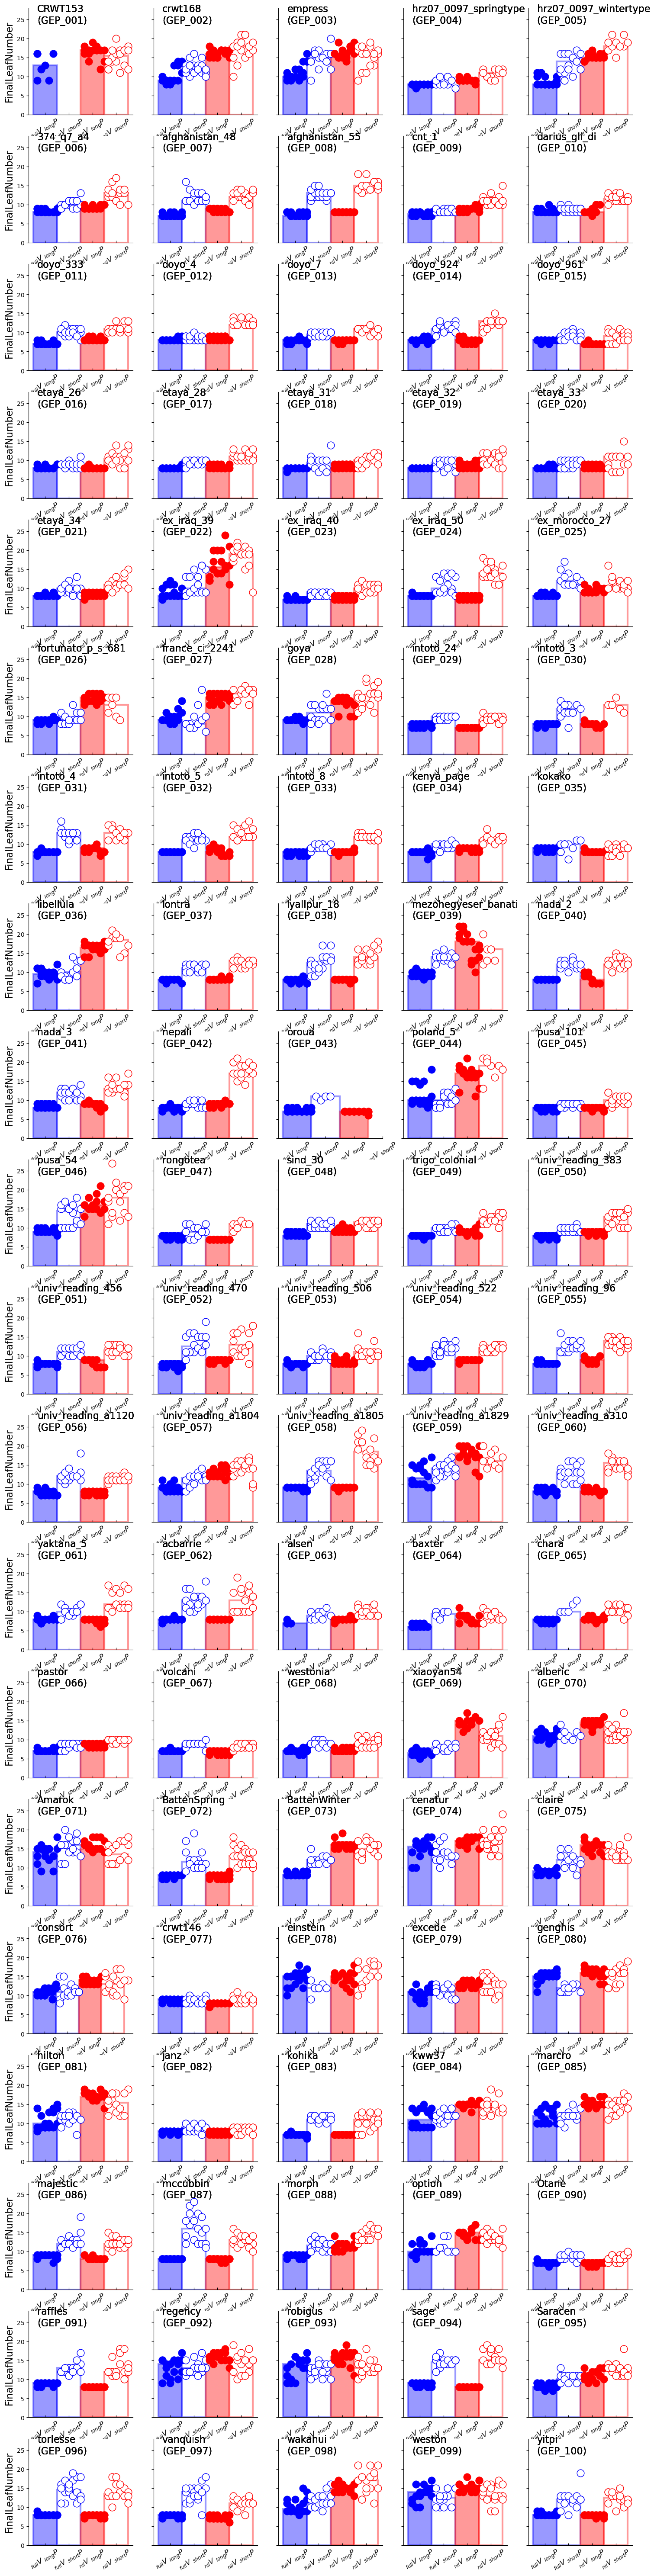

In [15]:
Fig = plt.figure(figsize=(18, 80))
Pos = 1
for Geno in Genotypes:
    Axis = Fig.add_subplot(21,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis)  
    Pos += 1
Fig.patch.set_facecolor('white')

## Data all looks good with no obvious outliers!!!

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\4134651427.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


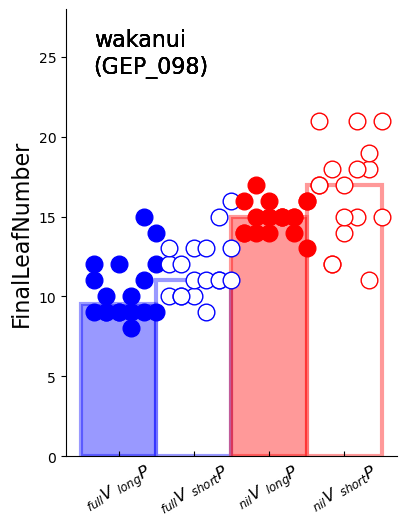

In [16]:
#Create a figure object
Fig = plt.figure(figsize=(18, 10))
colors = ['b','b','r','r']
fills = ['b','w','r','w']
Pos = 1
for Geno in ['GEP_098']:
    Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis) 
    Pos += 1
Fig.tight_layout()
Fig.patch.set_facecolor('white')

### Now lets look at how the mean FLN vary with Genotype and Vernalisation treatment

In [17]:
MedianData = Data.FinalLigualeNumber.groupby(level = ['Photoperiod','Vernalization','GEPCode']).median()
SEMData = 1.253 * Data.FinalLigualeNumber.groupby(level = ['Photoperiod','Vernalization','GEPCode']).std()/np.sqrt(Data.FinalLigualeNumber.groupby(level = ['Photoperiod','Vernalization','GEPCode']).std())

MedianData.loc[('8h','full','GEP_001')] = 14.0 #Number taken from detailed phenology experiments under same conditions
MedianData.loc[('8h','nil','GEP_043')] = np.nan  #Plant all failed to emerge.  Can't replace this with anything so put Nan to keep the gap

Upp = MedianData + SEMData
Low = MedianData - SEMData
FLNDataFrame = pd.DataFrame(MedianData)

In [18]:
FLNData = MasterIndex.join(FLNDataFrame, how='inner', lsuffix='left',rsuffix='right')
FLNData.loc[:,'FLNSEM'] = SEMData
FLNData.loc[:,'FLNUpp'] = Upp
FLNData.loc[:,'FLNLow'] = Low
FLNData.sort_index(inplace=True)

## Lets check the 6 genotypes from the phenology study against the phenotypes measured here

In [20]:
CoreFLNData = FLNData.loc[FLNData.loc[:,'Seed group'] =='Core']
CoreFLNData.set_index(keys='TidyName',append=True,drop=False,inplace=True)
CoreFLNData.index = CoreFLNData.index.droplevel(2)
CheckData = pd.read_csv('.\ProcessedData\PhenoStages.csv')
def PPconvert(pp):
    if pp == 8:
        return '8h'
    else:
        return '16h'
CheckData.loc[:,'Photoperiod'] = [PPconvert(x) for x in CheckData.PhotoP]
def VNconvert(vn):
    if vn == 'Full':
        return 'full'
    else:
        return 'nil'
CheckData.loc[:,'Vernalization'] = [VNconvert(x) for x in CheckData.Vern]
CheckCultNames = list(CheckData.Cult.drop_duplicates())
CoreFLNDataNames = list(CoreFLNData.index.get_level_values(2).drop_duplicates())
CoreFLNDataNames.sort()
NameMatch = pd.DataFrame(index = CheckCultNames,data=CoreFLNDataNames,columns=['CoreName'])
CheckData.loc[:,'TidyName']= [NameMatch.loc[x,'CoreName'] for x in CheckData.Cult]
CheckData.set_index(['Photoperiod','Vernalization','TidyName'],inplace=True)
CoreFLNData.loc[:,'CheckFLN'] = [CheckData.loc[x,'FLN'] for x in CoreFLNData.index]
CoreFLNData.index = CoreFLNData.index.swaplevel(0,2)

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\128837427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CoreFLNData.loc[:,'CheckFLN'] = [CheckData.loc[x,'FLN'] for x in CoreFLNData.index]


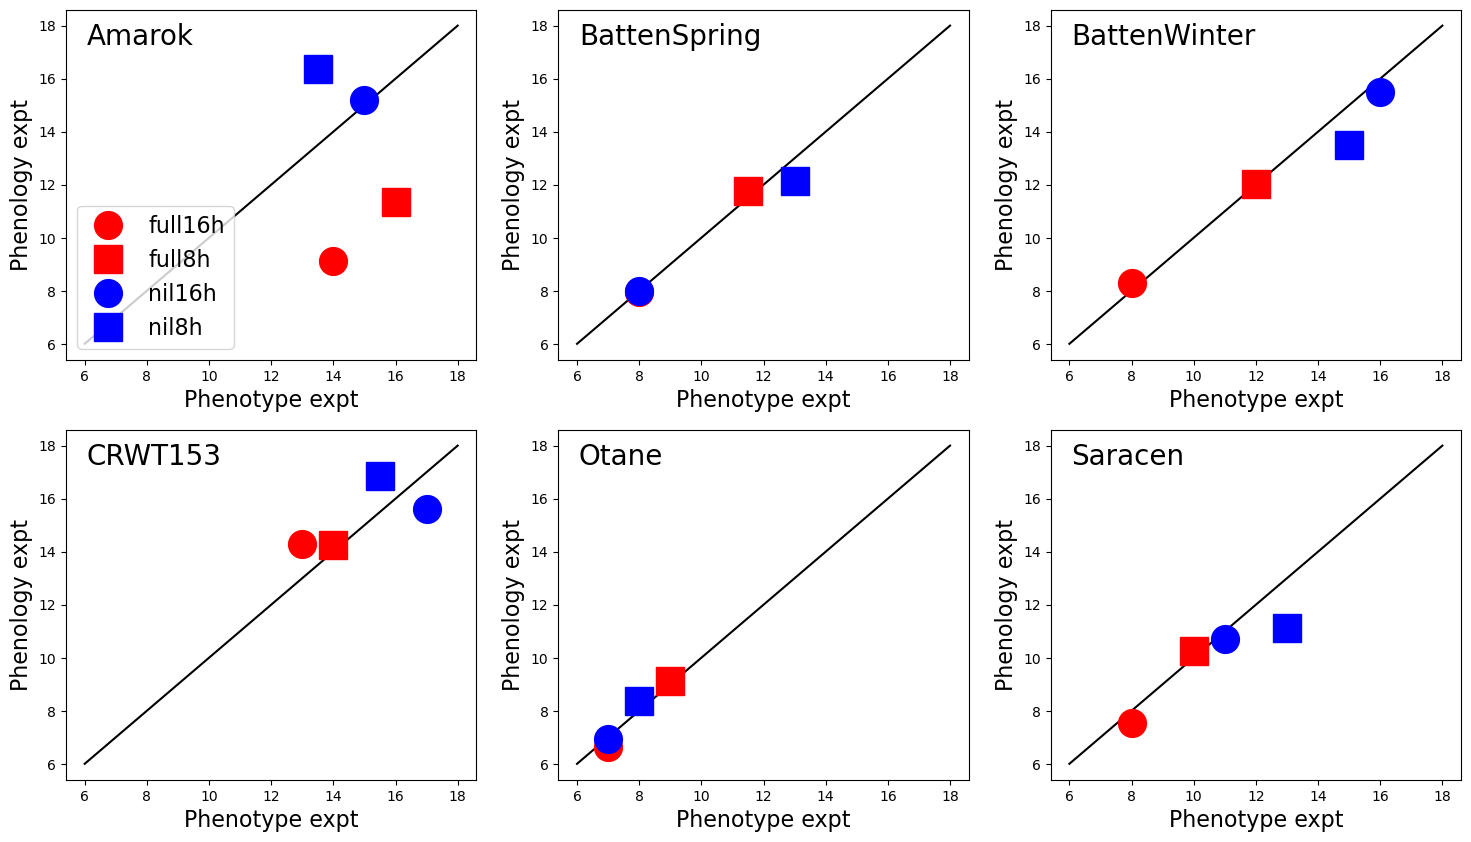

In [21]:
fig = plt.figure(figsize=(18,10))
col = ['r','b','r','b']
marker = ['o','s']
pos = 1
for Cult in CoreFLNDataNames:
    ax = fig.add_subplot(2,3,pos)
    plt.plot([6,18],[6,18],'-''k')
    colpos = 0
    for Vern in ['full','nil']:
        marpos = 0
        for Pp in ['16h','8h']:
            plt.plot(CoreFLNData.loc[(Cult,Vern,Pp),'FinalLigualeNumber'],
                     CoreFLNData.loc[(Cult,Vern,Pp),'CheckFLN'],
                    marker[marpos],color=col[colpos],ms=20,label=Vern+Pp)
            marpos+=1
        colpos +=1
    plt.text(0.05,0.9,Cult,fontsize=20,transform=ax.transAxes,horizontalalignment='left')
    plt.ylabel('Phenology expt',fontsize=16)
    plt.xlabel('Phenotype expt',fontsize=16)
    if pos == 1:
        plt.legend(loc=3,fontsize=16)
    pos += 1
Fig.patch.set_facecolor('white')

## There seems to be a problem with Amarok, No vernalisation response measured in the phenotype study but respose was measured in phenotype study, which makes more sense as is consistent with field observations

## Look at some final leaf number patterns

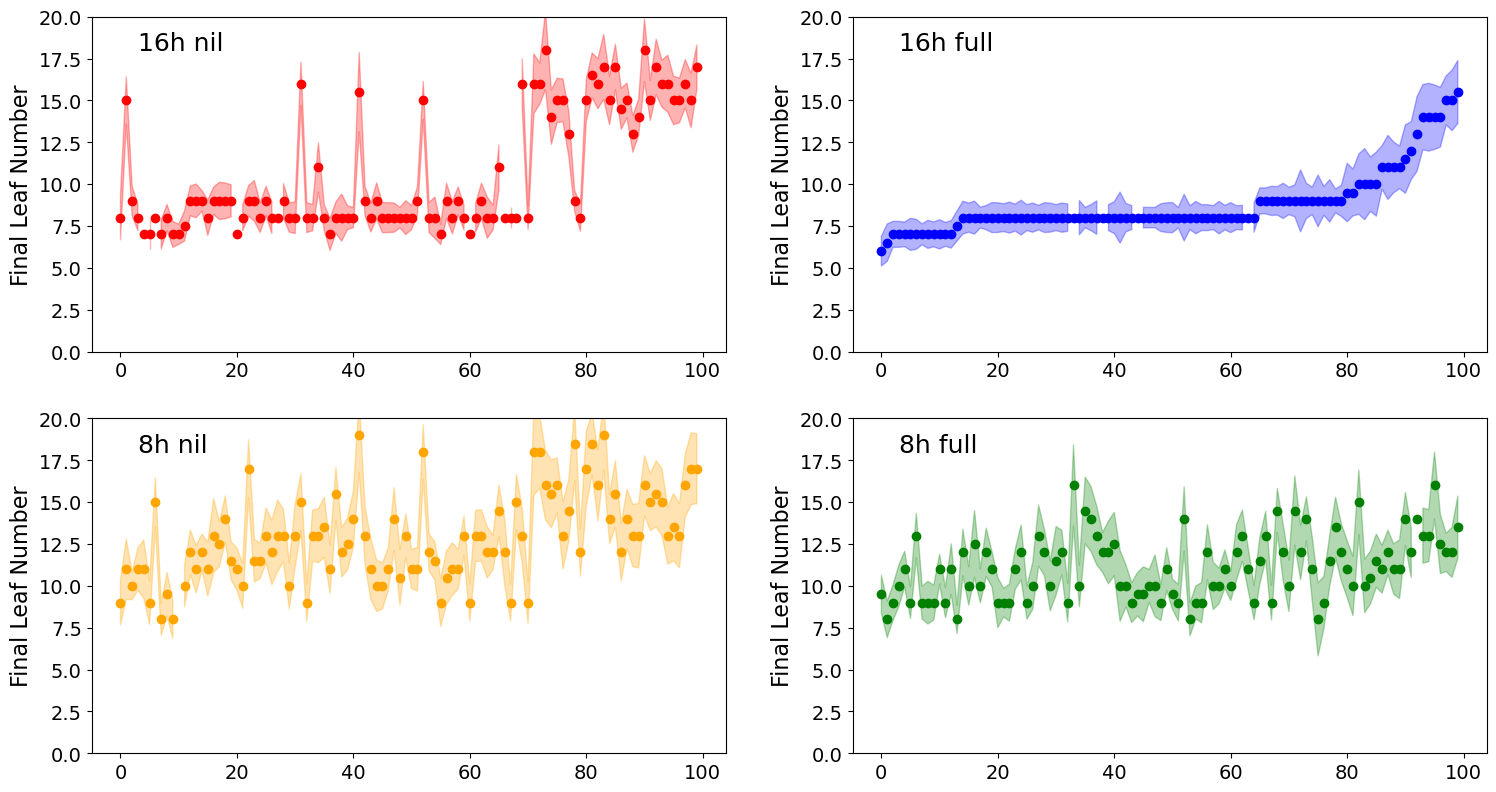

In [22]:
Graph = plt.figure(figsize=(18,20))

Pos = 1
Colors = ['r','b','orange','green']
Order = FLNData.loc[('16h','full'),'FinalLigualeNumber'].sort_values(inplace=False).index
for Pp in Photoperiods:
    for Vn in Vernalisations:
        Fig = Graph.add_subplot(4,2,Pos)
        Mean = FLNData.loc[(Pp,Vn),'FinalLigualeNumber'].loc[Order]
        SEM = FLNData.loc[(Pp,Vn),'FLNSEM'].loc[Order]
        Upp = Mean + SEM
        Low = Mean - SEM
        tit = Pp + ' ' + Vn
        plt.text(3,18,tit,fontsize=18)
        plt.plot(range(Mean.index.size),Mean,'o',color=Colors[Pos-1])
        plt.fill_between(range(Mean.index.size),Upp,Low,alpha=0.3,color=Colors[Pos-1])
        plt.ylabel('Final Leaf Number', fontsize = 16)
        plt.tick_params(labelsize=14)
        plt.ylim(0,20)
        Pos +=1
Fig.patch.set_facecolor('white')

## Calculate some phenotypes

In [23]:
#Replace FLN data for CoreSet with Data from Phenology set (which has more reps and no id issue with Amarok)
CoreNameMap = dict(zip(MasterIndex.loc[MasterIndex.loc[:,'Seed group']=='Core','TidyName'].values,
         MasterIndex.loc[MasterIndex.loc[:,'Seed group']=='Core','TidyName'].index))
for c in CheckData.index:
    FLNData.loc[(c[0],c[1],CoreNameMap[c[2]]),'FinalLigualeNumber'] = CheckData.loc[c,'FLN']

In [24]:
Full16HLN = FLNData.loc[('16h','full'),'FinalLigualeNumber']
Full16HLN.name = 'LV_FLN'
Full16HLNOrder = Full16HLN.sort_values(inplace=False).index
Full8HLN = FLNData.loc[('8h','full'),'FinalLigualeNumber']
Full8HLN.name = 'SV_FLN'
Full8HLNOrder = Full8HLN.sort_values(inplace=False).index
Nil16HLN = FLNData.loc[('16h','nil'),'FinalLigualeNumber']
Nil16HLN.name = 'LN_FLN'
Nil16HLNOrder = Nil16HLN.sort_values(inplace=False).index
Nil8HLN = FLNData.loc[('8h','nil'),'FinalLigualeNumber']
Nil8HLN.name = 'SN_FLN'
Nil8HLNOrder = Nil8HLN.sort_values(inplace=False).index

Phenotypes = MasterIndex.join(Full16HLN)
Phenotypes = Phenotypes.join(Full8HLN)
Phenotypes = Phenotypes.join(Nil16HLN)
Phenotypes = Phenotypes.join(Nil8HLN)

#Calculate some stuff for Minumum leaf numbers
MinLN = FLNData.loc[:,'FinalLigualeNumber'].groupby(by=['GEPCode']).min()
MinLN.name='MinLN'
MinLNOrder = MinLN.sort_values(inplace=False).index
MinLNTreat = pd.Series(index=Genotypes.values,name='MinLNTreat')
MinLNSEM = pd.Series(index=Genotypes.values,name='MinLNSEM')
for G in Genotypes.values:
    GMinLN = FLNData.loc[FLNData.index.isin([G],level=2),'FinalLigualeNumber'].min()
    for t in FLNData.loc[FLNData.index.isin([G],level=2),'FinalLigualeNumber'].index:
        if GMinLN == FLNData.loc[t,'FinalLigualeNumber']:
            MinLNTreat[G] = t
            MinLNSEM[G] = FLNData.loc[t,'FLNSEM']
MinLNTreat.name = 'MinLNTreat'
MinLNSEM.name = 'MinLNSEM'

#Stick all the phenotypes into a data frame
Phenotypes = Phenotypes.join(MinLN)
Phenotypes = Phenotypes.join(MinLNTreat)
Phenotypes = Phenotypes.join(MinLNSEM)

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\1628498853.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  MinLNTreat = pd.Series(index=Genotypes.values,name='MinLNTreat')
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\1628498853.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  MinLNSEM = pd.Series(index=Genotypes.values,name='MinLNSEM')


## Is the Full Vrn 16h Pp always the lowest FLN??

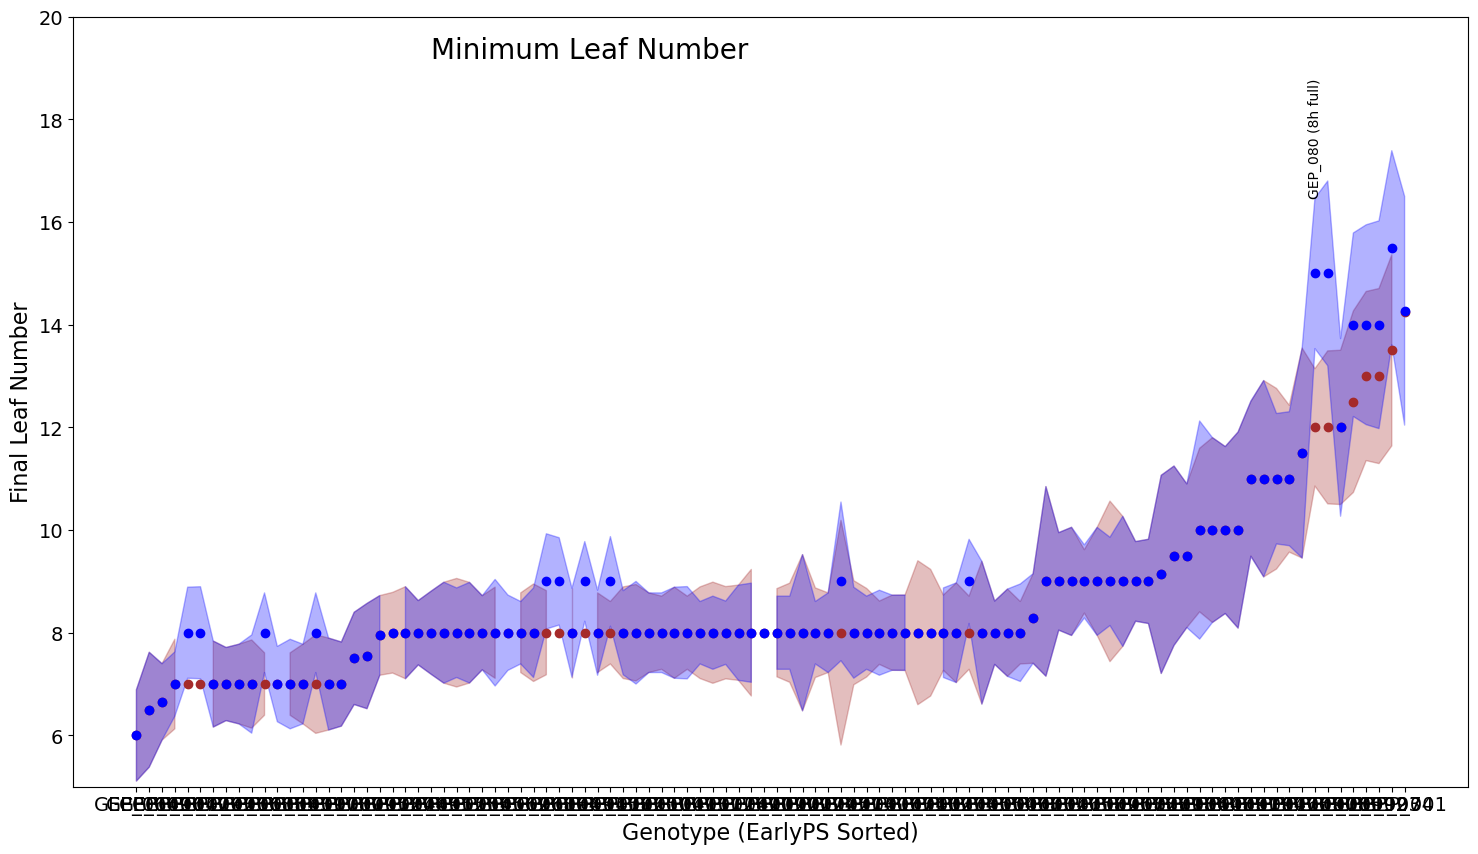

In [25]:
Graph = plt.figure(figsize=(18,10))

MinLN = MinLN[MinLNOrder]
MinLNSEM = Phenotypes.loc[MinLNOrder,'MinLNSEM']
MinLNupper = MinLN+MinLNSEM
MinLNlower = MinLN-MinLNSEM
plt.plot(MinLN,'o',color='brown',label='Min leaf number')
plt.fill_between(MinLN.index,MinLNupper,MinLNlower,alpha=0.3,color='brown')

full16h = FLNData.loc[('16h','full'),'FinalLigualeNumber'].loc[MinLNOrder]
full16hSEM = FLNData.loc[('16h','full'),'FLNSEM'].loc[MinLNOrder]
full16hupper = full16h+full16hSEM
full16hlower = full16h-full16hSEM
plt.plot(full16h.index,full16h,'o',color='b',label='16hPp FullVn')
plt.fill_between(full16h.index,full16hupper,full16hlower,alpha=0.3,color='b')

Oddities = []
for g in MinLN.index:
    if MinLNupper[g] < full16hlower[g]:
        txt = Phenotypes.loc[g,'MinLNTreat'][2]+' ('+Phenotypes.loc[g,'MinLNTreat'][0]+ ' '+Phenotypes.loc[g,'MinLNTreat'][1]+')'
        plt.text(g,full16h[g]+full16hSEM[g],txt,rotation=90, horizontalalignment='center',verticalalignment='bottom',)
        Oddities.append(g)
plt.ylabel('Final Leaf Number', fontsize = 16)
plt.xlabel('Genotype (EarlyPS Sorted)',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(5,20)
plt.text(23,19.2,'Minimum Leaf Number',fontsize=20)

Fig.patch.set_facecolor('white')
# plt.legend(loc=2,numpoints=1,fontsize=18)

# It looks like there are real wrong way photoperiod responses in Genghis and Einstein.  

In [26]:
Phenotypes.loc[Oddities,('TidyName', 'MinLN','LV_FLN', 'SV_FLN',
       'LN_FLN', 'SN_FLN', 'MinLNTreat')]

TidyName  MinLN  LV_FLN  SV_FLN  LN_FLN  SN_FLN           MinLNTreat
GEPCode                                                                     
GEP_080  genghis   12.0    15.0    12.0    16.0    16.0  (8h, full, GEP_080)

## Use the MinLN as a measure of earlyness perse but calculate Pp responses relative to 16h full treatment because wrong way responses are real

In [27]:
EarlyPS = MinLN.copy()#FLNData.loc[('16h','full'),'FinalLigualeNumber']
EarlyPS.name = 'EarlyPS'
EarlyPSOrder = EarlyPS.sort_values(inplace=False).index
Phenotypes = Phenotypes.join(EarlyPS)

## First lets look at the vernalisation response

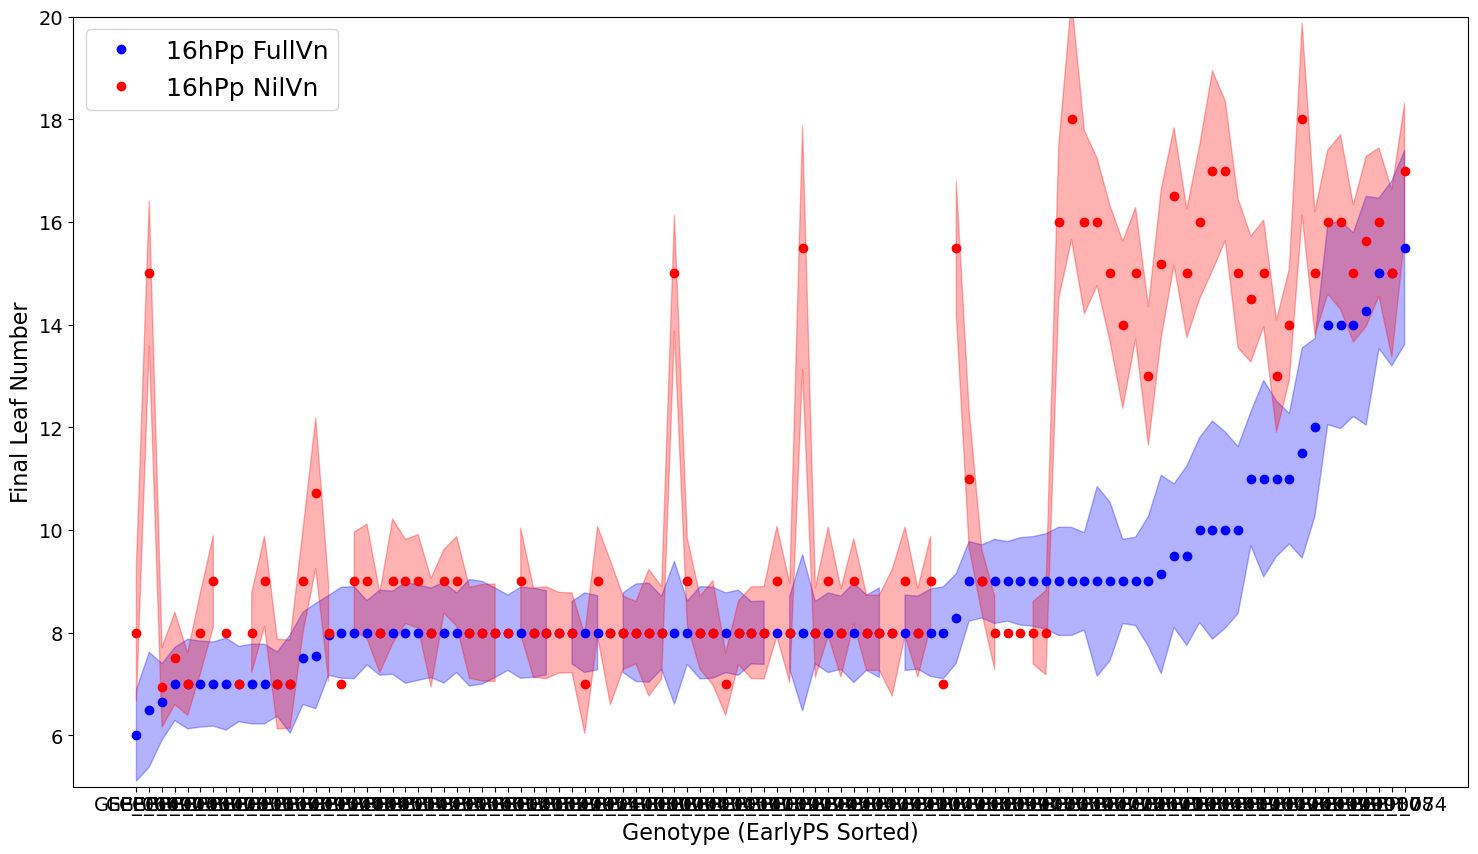

In [28]:
Graph = plt.figure(figsize=(18,10))

full16h = FLNData.loc[('16h','full'),'FinalLigualeNumber'].loc[Full16HLNOrder]
full16hSEM = FLNData.loc[('16h','full'),'FLNSEM'].loc[Full16HLNOrder]
full16hupper = full16h+full16hSEM
full16hlower = full16h-full16hSEM
plt.plot(full16h.index,full16h,'o',color='b',label='16hPp FullVn')
plt.fill_between(full16h.index,full16hupper,full16hlower,alpha=0.3,color='b')

full8h = FLNData.loc[('16h','nil'),'FinalLigualeNumber'].loc[Full16HLNOrder]
full8hSEM = FLNData.loc[('16h','nil'),'FLNSEM'].loc[Full16HLNOrder]
full8hupper = full8h+full8hSEM
full8hlower = full8h-full8hSEM
plt.plot(full8h.index,full8h,'o',color='r',label='16hPp NilVn')
plt.fill_between(full8h.index,full8hupper,full8hlower,alpha=0.3,color='r')

plt.ylabel('Final Leaf Number', fontsize = 16)
plt.xlabel('Genotype (EarlyPS Sorted)',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(5,20)
plt.legend(loc=2,numpoints=1,fontsize=18)

## Vernalisatin response is pretty clean.  Some negatives but I think these will be noise, should these be zero set?

In [29]:
## Set any phenotype to zero where the FLN of Vern and UnVern treatments 
## are not significantly different
VernSens = FLNData.loc[('16h','nil'),'FinalLigualeNumber'].loc[EarlyPSOrder] - FLNData.loc[('16h','full'),'FinalLigualeNumber'].loc[EarlyPSOrder]
for g in Genotypes:
        try:
            full = Data.loc[(g,'full','16h'),'FinalLigualeNumber'].sort_values()
            nil = Data.loc[(g,'nil','8h'),'FinalLigualeNumber'].sort_values()
            p = stats.kruskal(full,nil,nan_policy='omit').pvalue
            if p>0.05:
                VernSens[g] = 0
        except:
            do = 'nothing'
VernSens.name = 'VernSens'
VernSensOrder = VernSens.sort_values(inplace=False).index
Phenotypes = Phenotypes.join(VernSens)

## Now lets investigate photoperiod responses

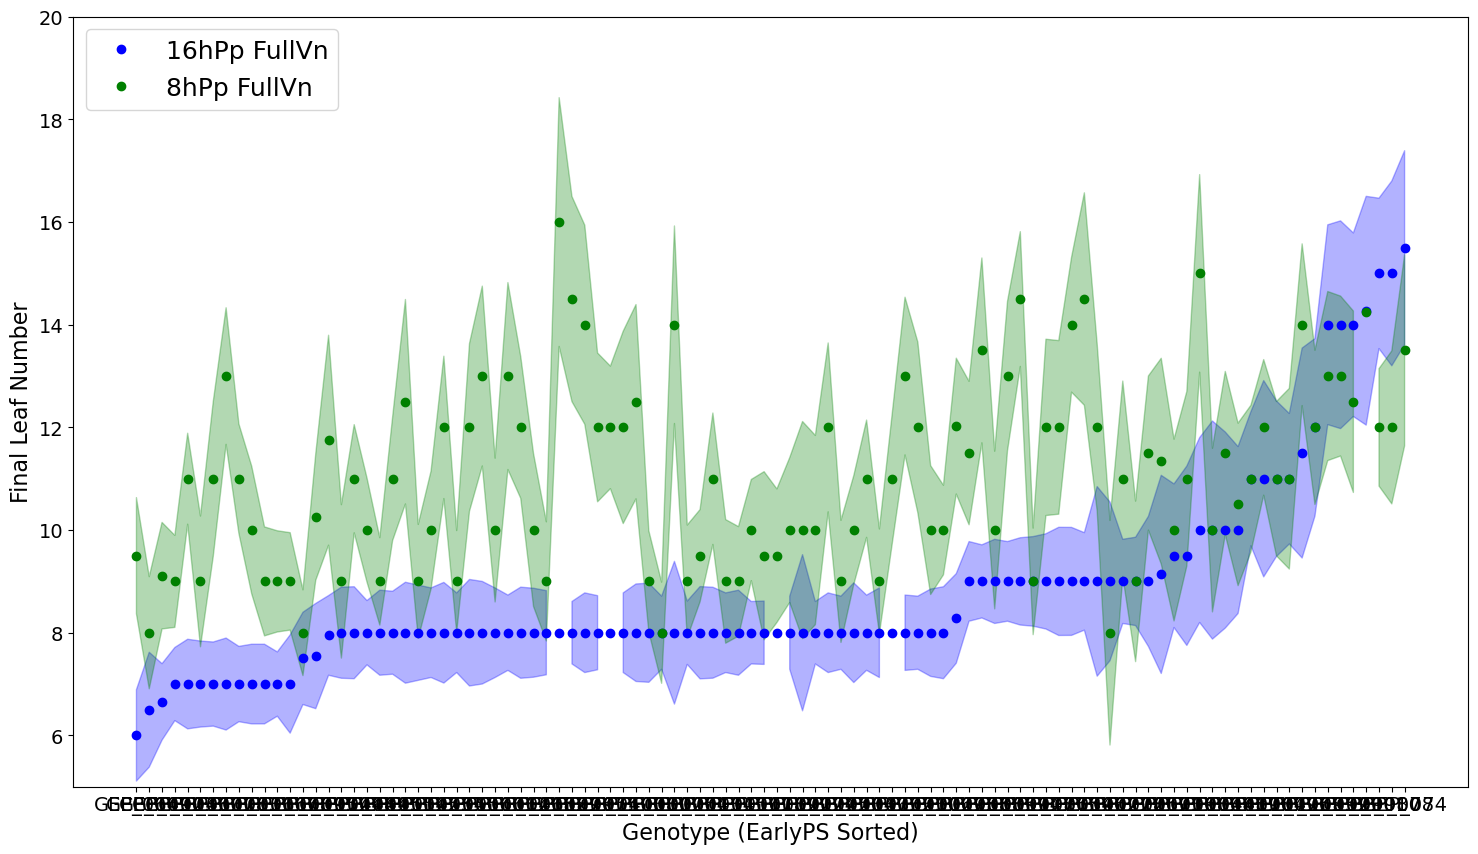

In [30]:
Graph = plt.figure(figsize=(18,10))

full16h = FLNData.loc[('16h','full'),'FinalLigualeNumber'].loc[Full16HLNOrder]
full16hSEM = FLNData.loc[('16h','full'),'FLNSEM'].loc[Full16HLNOrder]
full16hupper = full16h+full16hSEM
full16hlower = full16h-full16hSEM
plt.plot(full16h.index,full16h,'o',color='b',label='16hPp FullVn')
plt.fill_between(full16h.index,full16hupper,full16hlower,alpha=0.3,color='b')

full8h = FLNData.loc[('8h','full'),'FinalLigualeNumber'].loc[Full16HLNOrder]
full8hSEM = FLNData.loc[('8h','full'),'FLNSEM'].loc[Full16HLNOrder]
full8hupper = full8h+full8hSEM
full8hlower = full8h-full8hSEM
plt.plot(full8h.index,full8h,'o',color='g',label='8hPp FullVn')
plt.fill_between(full8h.index,full8hupper,full8hlower,alpha=0.3,color='g')

plt.ylabel('Final Leaf Number', fontsize = 16)
plt.xlabel('Genotype (EarlyPS Sorted)',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(5,20)
plt.legend(loc=2,numpoints=1,fontsize=18)
Fig.patch.set_facecolor('white')

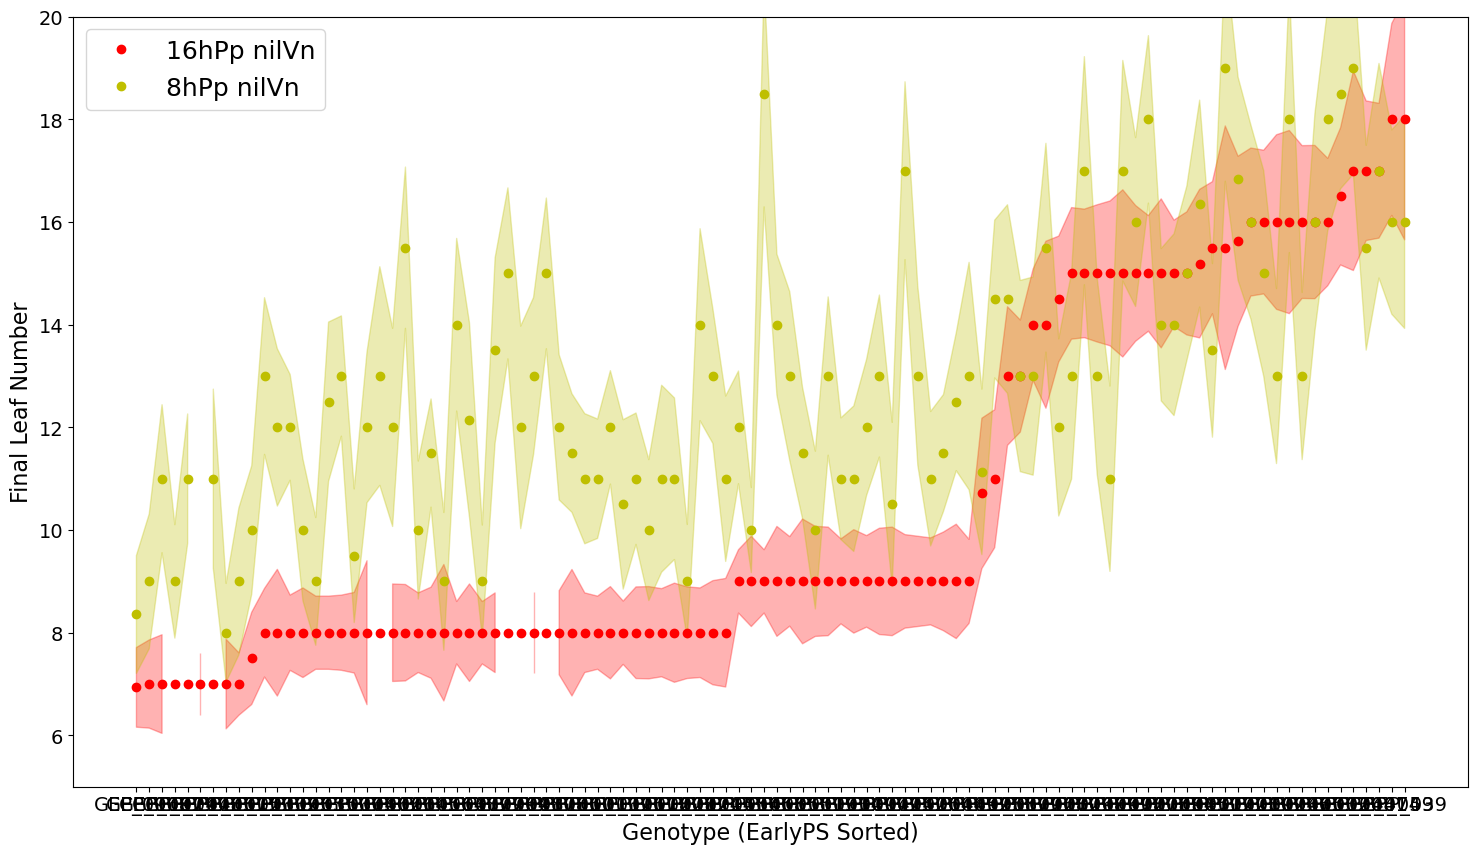

In [31]:
Graph = plt.figure(figsize=(18,10))

nil16h = FLNData.loc[('16h','nil'),'FinalLigualeNumber'].loc[Nil16HLNOrder]
nil16hSEM = FLNData.loc[('16h','nil'),'FLNSEM'].loc[Nil16HLNOrder]
nil16hupper = nil16h+nil16hSEM
nil16hlower = nil16h-nil16hSEM
plt.plot(nil16h.index,nil16h,'o',color='r',label='16hPp nilVn')
plt.fill_between(nil16h.index,nil16hupper,nil16hlower,alpha=0.3,color='r')

nil8h = FLNData.loc[('8h','nil'),'FinalLigualeNumber'].loc[Nil16HLNOrder]
nil8hSEM = FLNData.loc[('8h','nil'),'FLNSEM'].loc[Nil16HLNOrder]
nil8hupper = nil8h+nil8hSEM
nil8hlower = nil8h-nil8hSEM
plt.plot(nil8h.index,nil8h,'o',color='y',label='8hPp nilVn')
plt.fill_between(nil8h.index,nil8hupper,nil8hlower,alpha=0.3,color='y')

plt.ylabel('Final Leaf Number', fontsize = 16)
plt.xlabel('Genotype (EarlyPS Sorted)',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(5,20)
plt.legend(loc=2,numpoints=1,fontsize=18)
Fig.patch.set_facecolor('white')

## Photoperiod responses are pretty clean for the varieties with low FLN under full vrn but become a bit messy for higher FLN varieties. 

## Use the difference between the two to quantify Photoperiod sensitivity both with and without vernalisation

In [32]:
## Set any phenotype to zero where the FLN of Long and short day treatments 
## are not significantly different
FVPPSens = FLNData.loc[('8h','full'),'FinalLigualeNumber'].loc[EarlyPSOrder] - FLNData.loc[('16h','full'),'FinalLigualeNumber'].loc[EarlyPSOrder]
NVPPSens = FLNData.loc[('8h','nil'),'FinalLigualeNumber'].loc[EarlyPSOrder] - FLNData.loc[('16h','nil'),'FinalLigualeNumber'].loc[EarlyPSOrder]
for g in Genotypes:
        try:
            FVlong = Data.loc[(g,'full','16h'),'FinalLigualeNumber'].sort_values()
            FVshort = Data.loc[(g,'full','8h'),'FinalLigualeNumber'].sort_values()
            NVlong = Data.loc[(g,'nil','16h'),'FinalLigualeNumber'].sort_values()
            NVshort = Data.loc[(g,'nil','8h'),'FinalLigualeNumber'].sort_values()
            p = stats.kruskal(FVlong,FVshort,nan_policy='omit').pvalue
            if p>0.05:
                FVPPSens[g] = 0
            p = stats.kruskal(NVlong,NVshort,nan_policy='omit').pvalue
            if p>0.05:
                NVPPSens[g] = 0
        except:
            do = 'nothing'
        
FVPPSensOrder = FVPPSens.sort_values(inplace=False).index
FVPPSens.name = 'FVPPSens'
Phenotypes = Phenotypes.join(FVPPSens)
NVPPSensOrder = NVPPSens.sort_values(inplace=False).index
NVPPSens.name = 'NVPPSens'
Phenotypes = Phenotypes.join(NVPPSens)

## Now lets look at short day vernalisation response

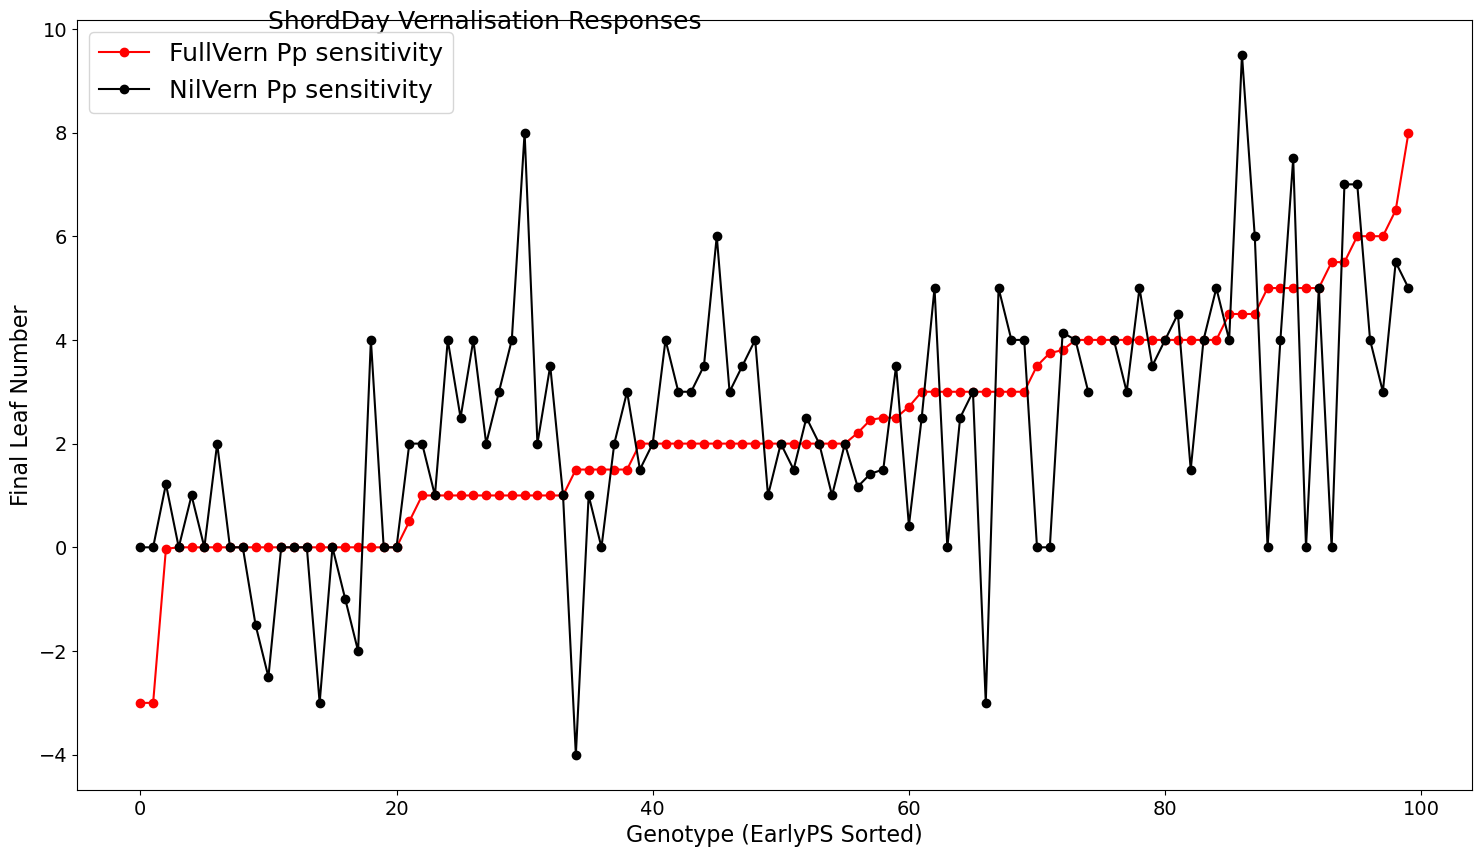

In [33]:
Graph = plt.figure(figsize=(18,10))
First = FVPPSens[FVPPSensOrder]
Second = NVPPSens[FVPPSensOrder]
plt.text(10,10,'ShordDay Vernalisation Responses',fontsize=18)
plt.plot(range(First.index.size),First,'o-',color='r',label='FullVern Pp sensitivity')
plt.ylabel('Final Leaf Number', fontsize = 16)
plt.plot(range(Second.index.size),Second,'o-',color='k',label='NilVern Pp sensitivity',picker=True)
plt.xlabel('Genotype (EarlyPS Sorted)',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc=2,numpoints=1,fontsize=18)
Fig.patch.set_facecolor('white')

In [34]:
SDVS0 = EarlyPS.loc[FVPPSensOrder] + VernSens.loc[FVPPSensOrder] + FVPPSens.loc[FVPPSensOrder]
SDVS0.name = 'SDVS0'
SDVS0Order = SDVS0.sort_values(inplace=False).index
SDVnSens = SDVS0.loc[FVPPSensOrder] - FLNData.loc[('8h','nil'),'FinalLigualeNumber'].loc[EarlyPSOrder]
for g in Genotypes:
        if Phenotypes.loc[g,'VernSens']<1.0:
            SDVnSens[g] = 0
SDVnSens.name = 'SDVnSens'
SDVnSensOrder = SDVnSens.sort_values(inplace=False).index
VnPPint = FVPPSens - NVPPSens
VnPPintOrder = VnPPint.sort_values(inplace=False).index
VnPPint.name = 'VnPPint'
Phenotypes = Phenotypes.join(SDVS0)
Phenotypes = Phenotypes.join(SDVnSens)
Phenotypes = Phenotypes.join(VnPPint)

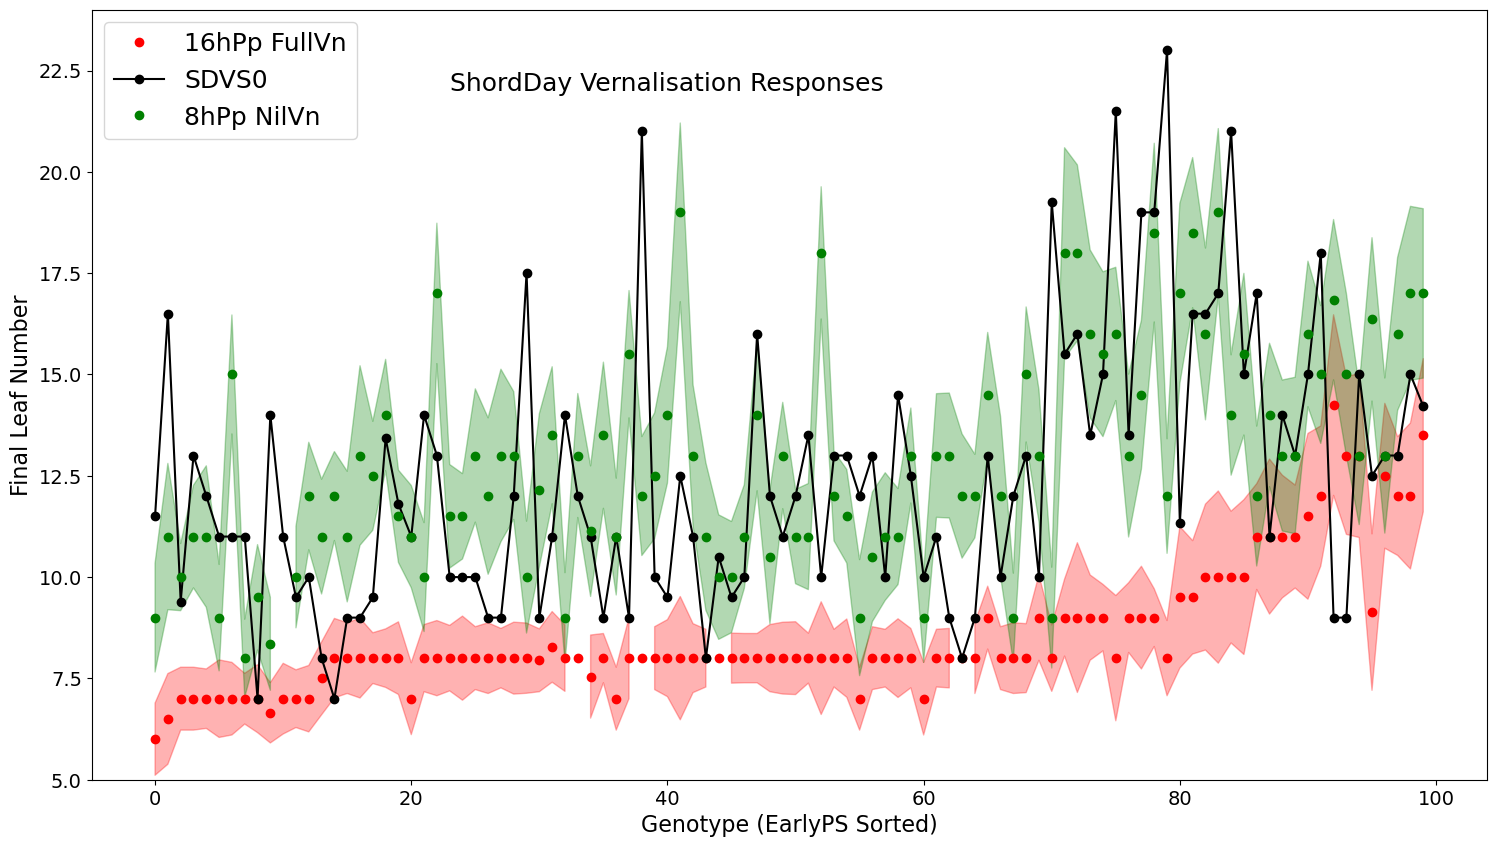

In [35]:
Graph = plt.figure(figsize=(18,10))
First = EarlyPS.loc[Order]#FLNData.loc[('16h','full'),'FinalLigualeNumber'].loc[Order]
FirstSEM = FLNData.loc[('16h','full'),'FLNSEM'].loc[Order]
Second = SDVS0.loc[EarlyPSOrder]
#SecondSEM = FLNData.loc[('16h','nil'),'FLNSEM'].loc[Order]
Third = FLNData.loc[('8h','nil'),'FinalLigualeNumber'].loc[Order]
ThirdSEM = FLNData.loc[('8h','nil'),'FLNSEM'].loc[Order]
plt.text(23,22,'ShordDay Vernalisation Responses',fontsize=18)
plt.plot(range(First.index.size),First,'o',color='r',label='16hPp FullVn')
plt.fill_between(range(First.index.size),First+FirstSEM,First-FirstSEM,alpha=0.3,color='r')
plt.ylabel('Final Leaf Number', fontsize = 16)
plt.plot(range(Second.index.size),Second,'o-',color='k',label='SDVS0',picker=True)
#plt.fill_between(range(Second.index.size),Second+SecondSEM,Second-SecondSEM,alpha=0.3,color='orange')
plt.plot(range(Third.index.size),Third,'o',color='g',label='8hPp NilVn')
plt.fill_between(range(Third.index.size),Third+ThirdSEM,Third-ThirdSEM,alpha=0.3,color='g')
plt.xlabel('Genotype (EarlyPS Sorted)',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc=2,numpoints=1,fontsize=18)
plt.ylim(5,24)
Pos +=1
Fig.patch.set_facecolor('white')

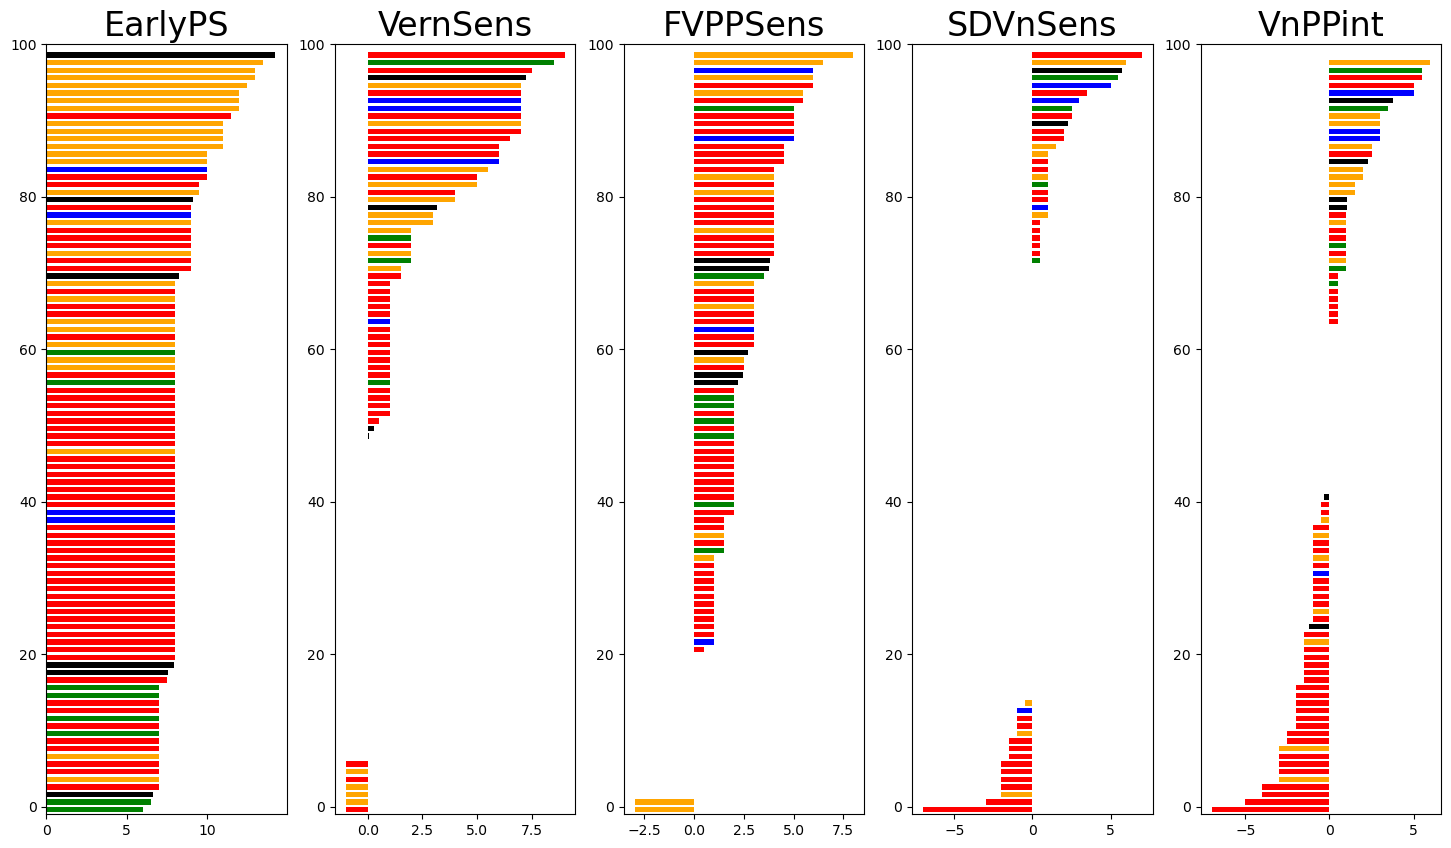

In [36]:
Graph = plt.figure(figsize=(18,10))
depth = 0.7
ind = np.arange(100) - 0.4
p=1
sortOrders = [EarlyPSOrder,VernSensOrder,FVPPSensOrder,SDVnSensOrder, VnPPintOrder]
for var in [ 'EarlyPS', 'VernSens','FVPPSens', 'SDVnSens','VnPPint']:
    Colors = [SeedColors.loc[Phenotypes.loc[sortOrders[p-1],'Seed group'][x],'Colors'] for x in range(Phenotypes.index.size)]
    ax = Graph.add_subplot(1,5,p)
    ax.bar(x=0, width = Phenotypes.loc[sortOrders[p-1],var],height = depth, bottom=ind,
           color = Colors,orientation='horizontal')
    ax.set_ylim(-1,100)
    plt.title(var,fontsize=24)
    p+=1
Graph.patch.set_facecolor('white')

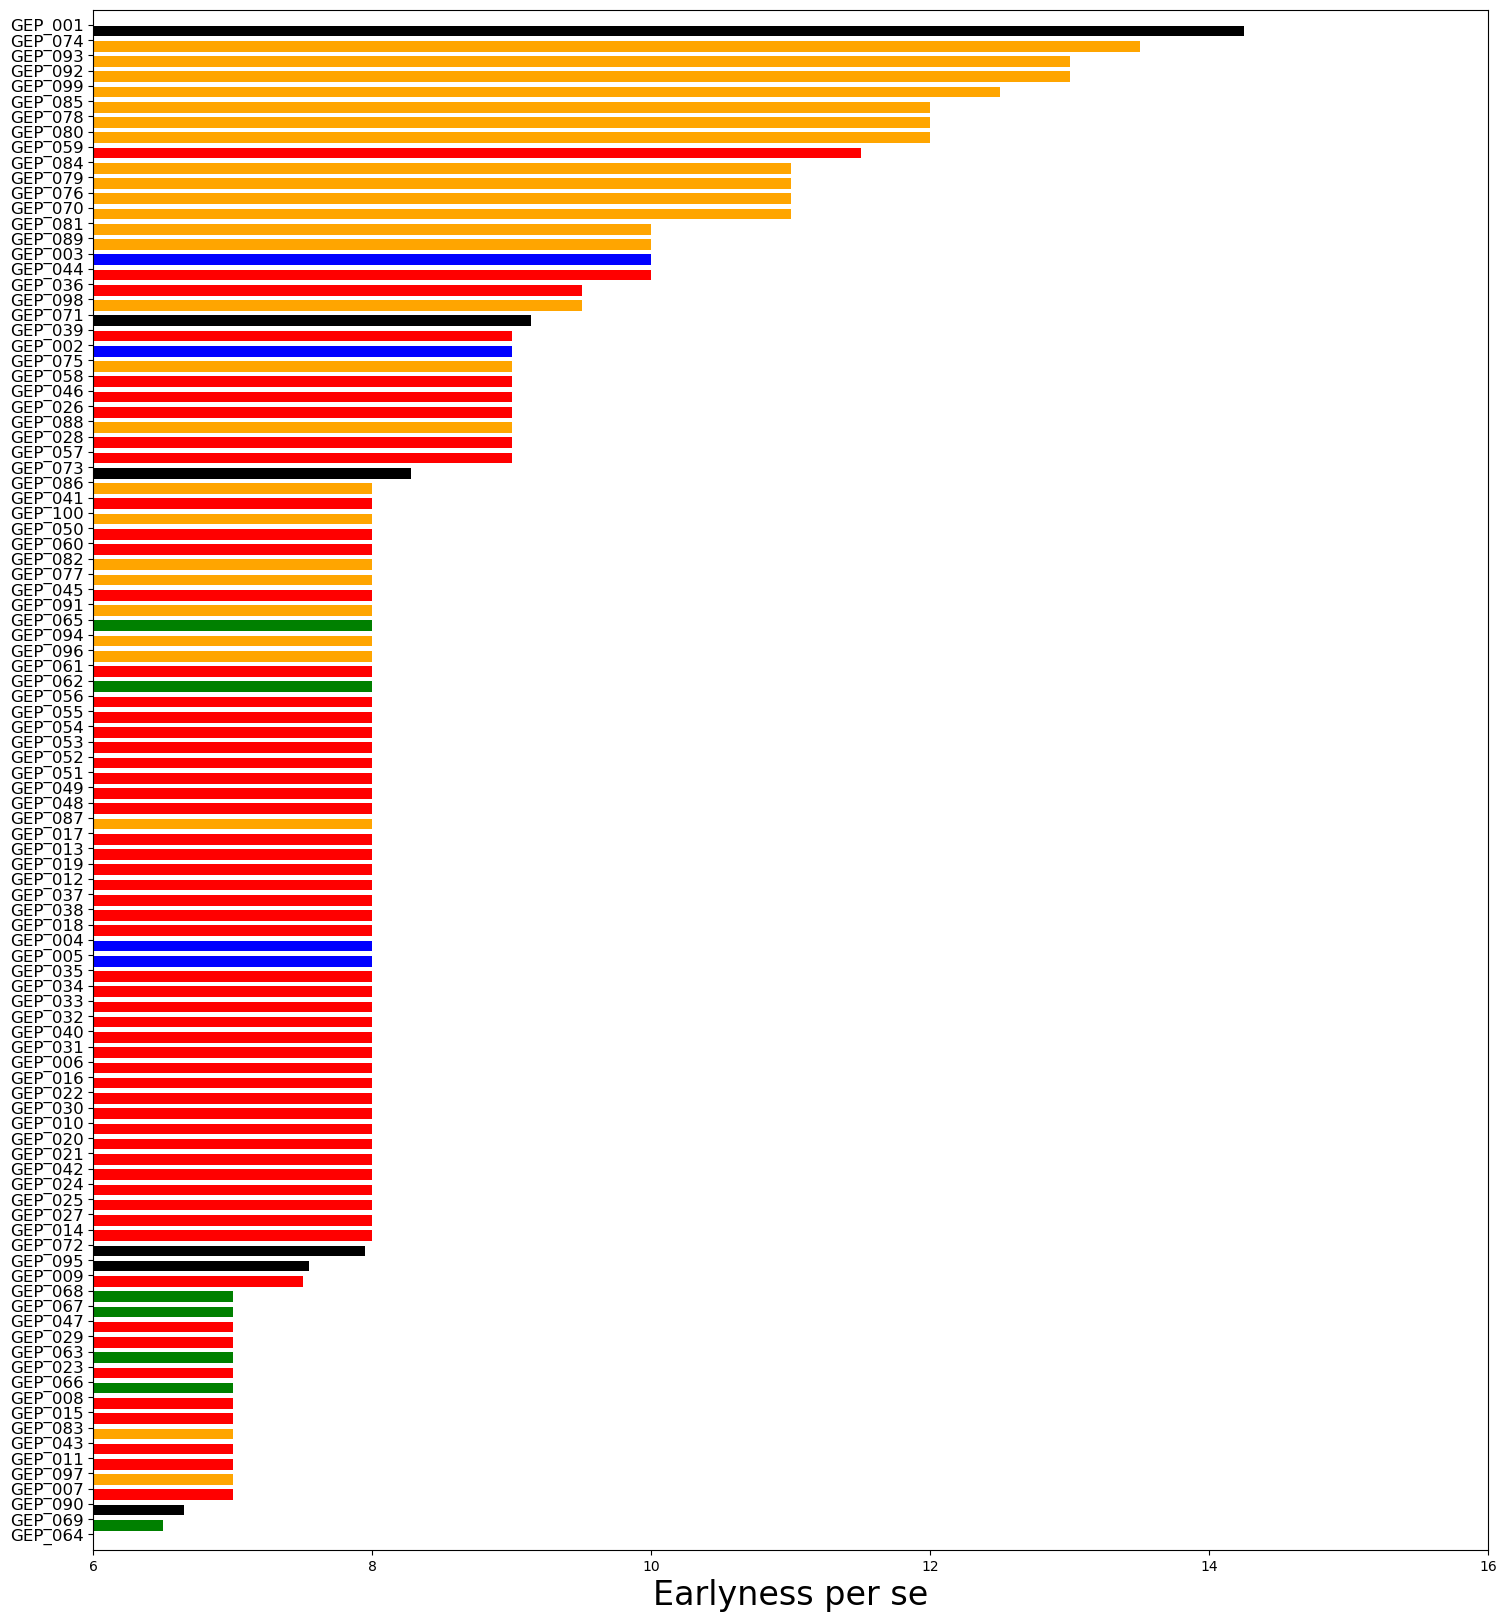

In [37]:
Colors = [SeedColors.loc[Phenotypes.loc[EarlyPSOrder,'Seed group'][x],'Colors'] for x in range(Phenotypes.index.size)]
depth = 0.7
ind = np.arange(100) - 0.4
fig, ax = plt.subplots(figsize=(18, 20))
ax.bar(x=0, width = Phenotypes.loc[EarlyPSOrder,'EarlyPS'],height = depth, bottom=ind,color = Colors,orientation='horizontal')
ax.set_yticks(range(0,100))
ax.set_yticklabels(Phenotypes.loc[EarlyPSOrder,'TidyName'].index,fontsize=12)
ax.set_xlim(6,16)
ax.set_ylim(-1,100)
ax.set_xlabel('Earlyness per se',fontsize=24)
Fig.patch.set_facecolor('white')

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\3378391855.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


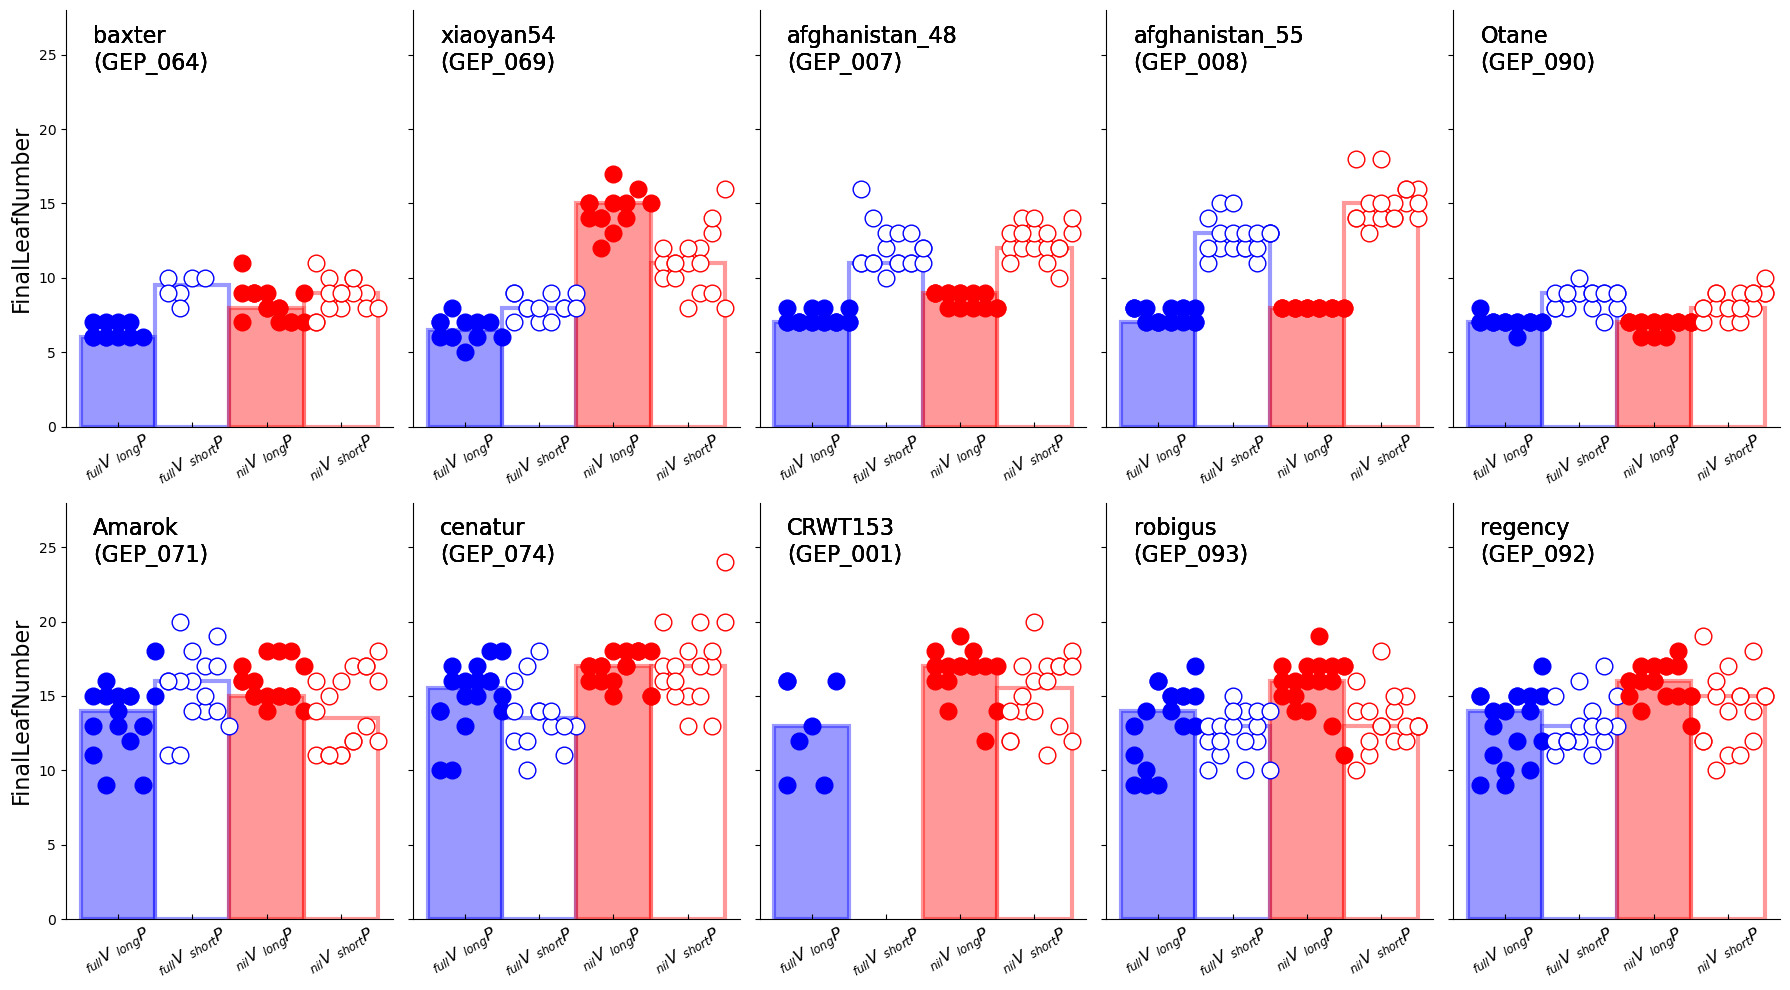

In [38]:
#Create a figure object
Fig = plt.figure(figsize=(18, 10))
colors = ['b','b','r','r']
fills = ['b','w','r','w']
Pos = 1
for Geno in ['GEP_064','GEP_069','GEP_007','GEP_008','GEP_090',
            'GEP_071','GEP_074','GEP_001','GEP_093','GEP_092']:
    Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis) 
    Pos += 1
Fig.tight_layout()
Fig.patch.set_facecolor('white')

### The earlyest ones have nice clean data.  The late ones are quite messy

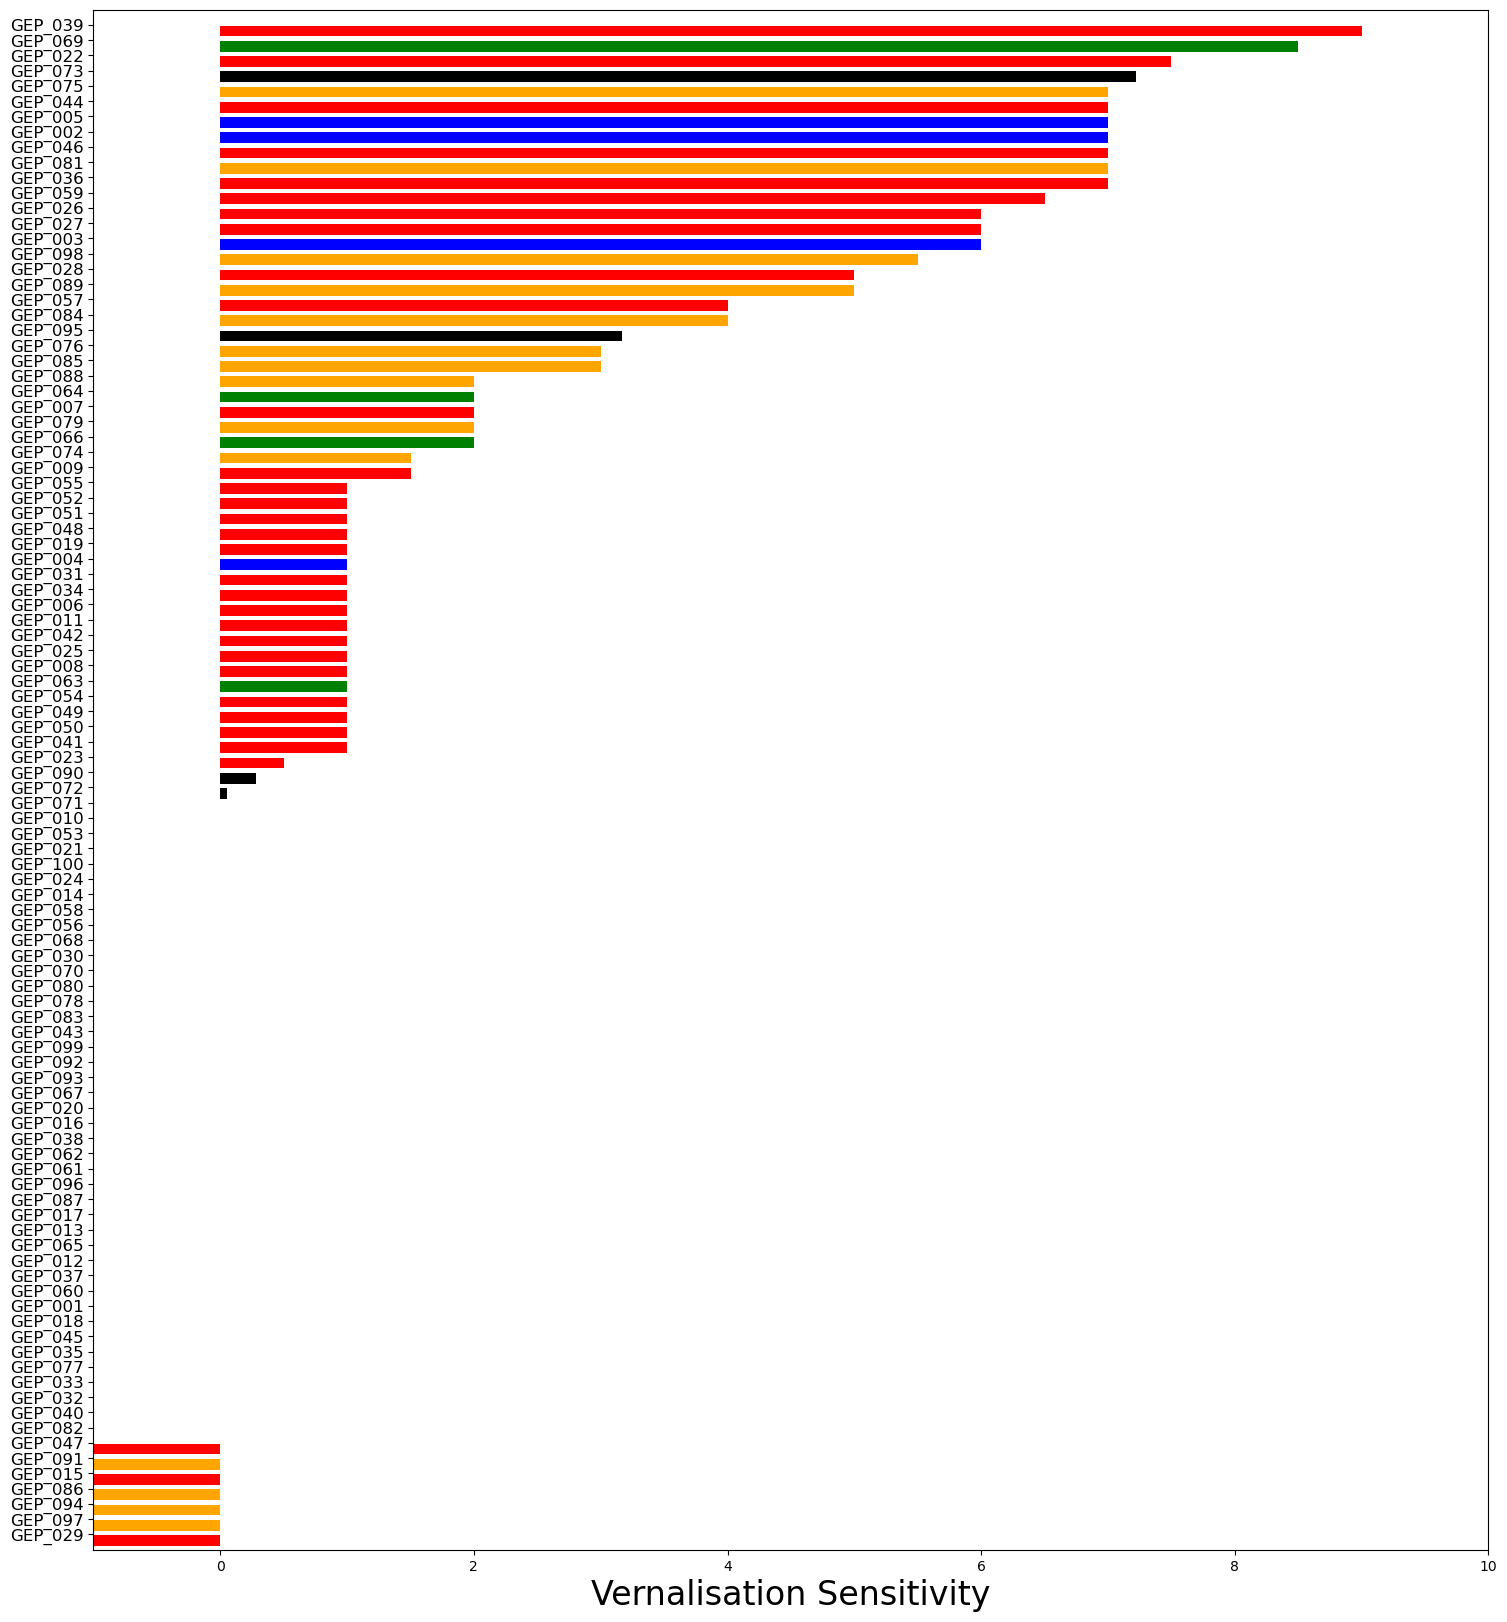

In [39]:
Colors = [SeedColors.loc[Phenotypes.loc[VernSensOrder,'Seed group'][x],'Colors'] for x in range(Phenotypes.index.size)]
depth = 0.7
ind = np.arange(100) - 0.4
fig, ax = plt.subplots(figsize=(18, 20))
ax.bar(x=0, width = Phenotypes.loc[VernSensOrder,'VernSens'],height = depth, bottom=ind,color = Colors,orientation='horizontal')
ax.set_yticks(range(0,100))
ax.set_yticklabels(Phenotypes.loc[VernSensOrder,'TidyName'].index,fontsize=12)
ax.set_xlim(-1,10)
ax.set_ylim(-1,100)
ax.set_xlabel('Vernalisation Sensitivity',fontsize=24)
Fig.patch.set_facecolor('white')

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\4156443914.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


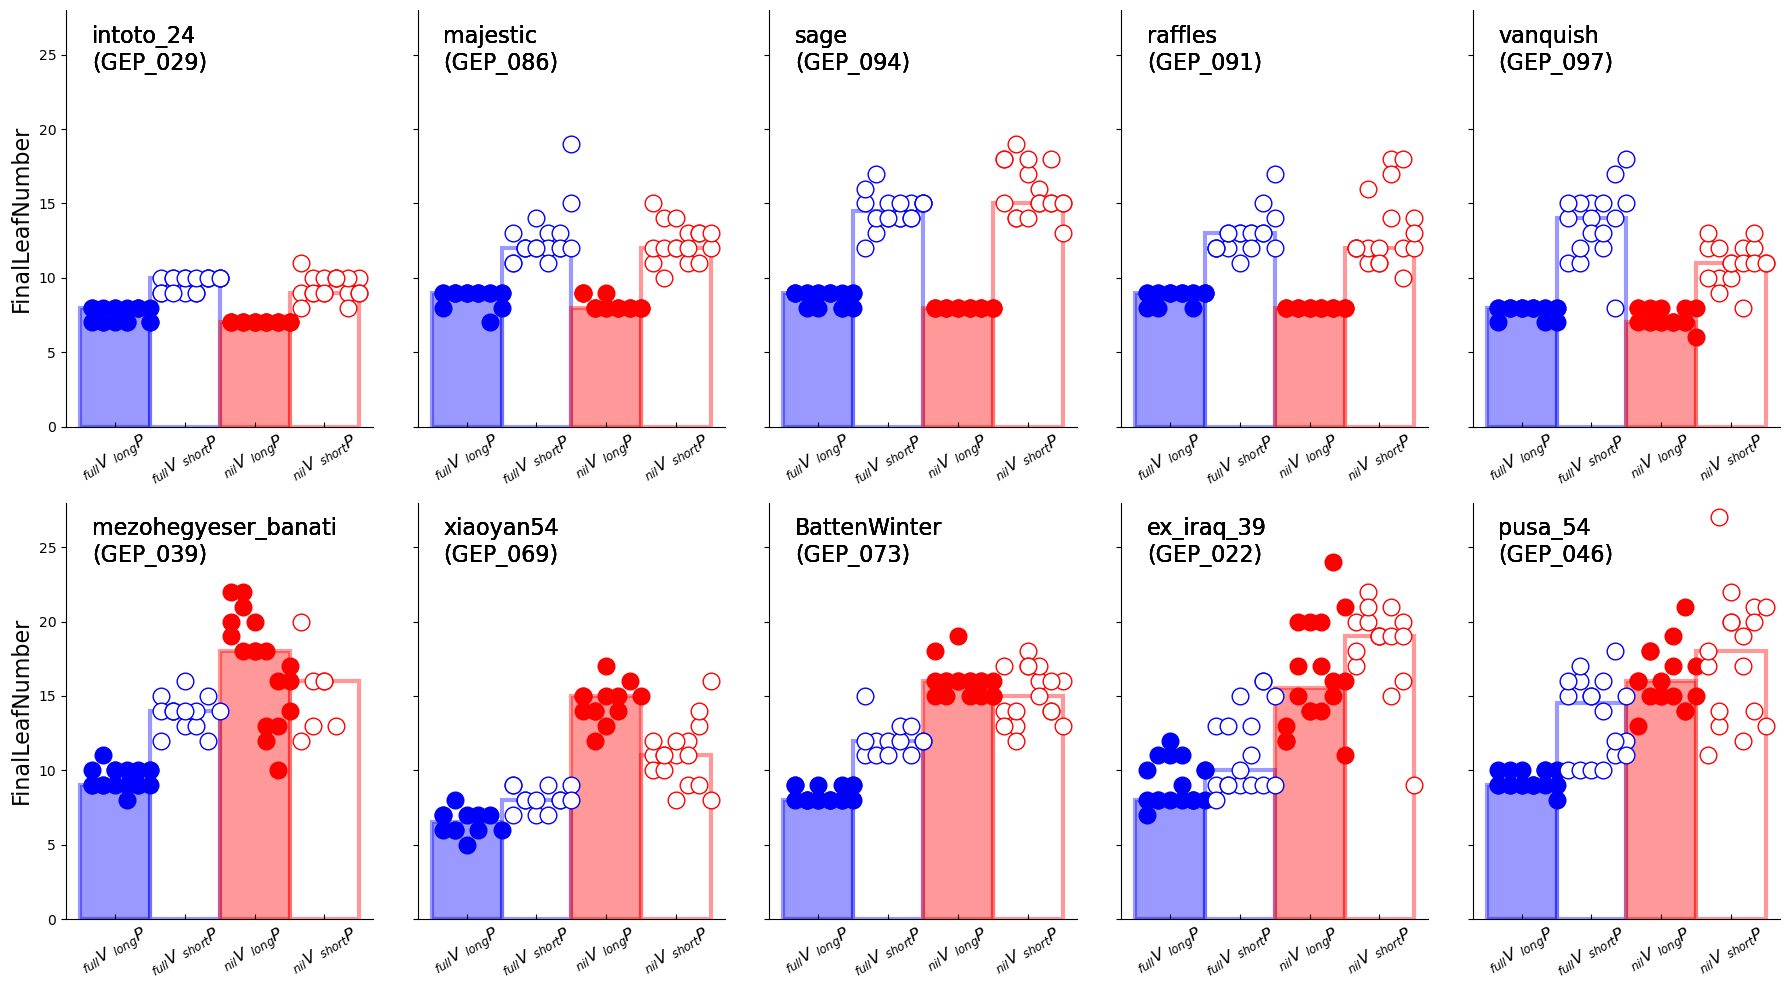

In [40]:
#Create a figure object
Fig = plt.figure(figsize=(18, 10))
colors = ['b','b','r','r']
fills = ['b','w','r','w']
Pos = 1
for Geno in ['GEP_029','GEP_086','GEP_094','GEP_091','GEP_097',
             'GEP_039','GEP_069','GEP_073','GEP_022','GEP_046']:
    Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis) 
    Pos += 1
Fig.tight_layout()
Fig.patch.set_facecolor('white')

## Nothing pecular looking about the first 5 negative vern responses, either real of just noise

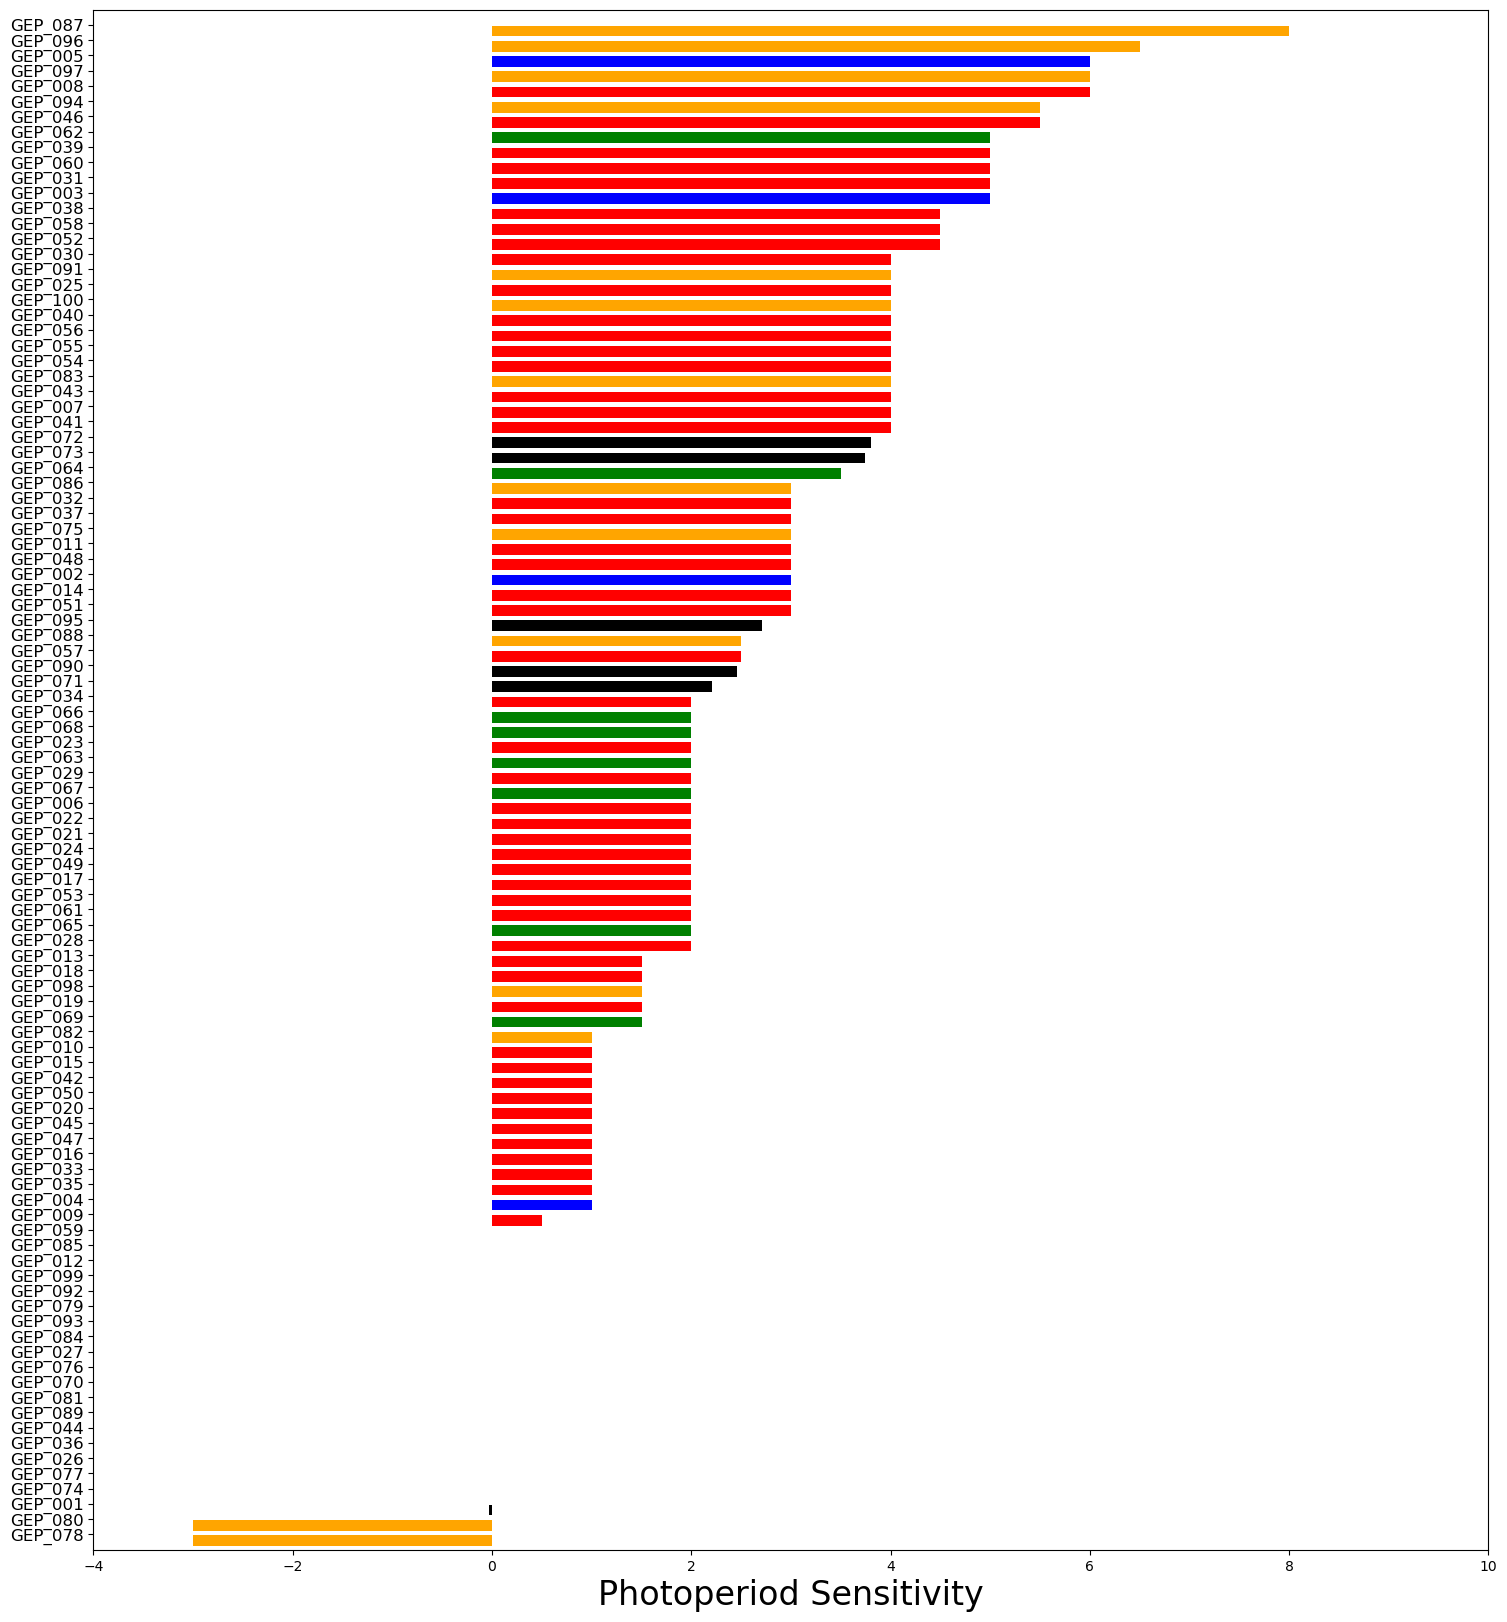

In [41]:
Colors = [SeedColors.loc[Phenotypes.loc[FVPPSensOrder,'Seed group'][x],'Colors'] for x in range(Phenotypes.index.size)]
depth = 0.7
ind = np.arange(100) - 0.4
fig, ax = plt.subplots(figsize=(18, 20))
ax.bar(x=0, width = Phenotypes.loc[FVPPSensOrder,'FVPPSens'],height = depth, bottom=ind,color = Colors,orientation='horizontal')
ax.set_yticks(range(0,100))
ax.set_yticklabels(Phenotypes.loc[FVPPSensOrder,'TidyName'].index,fontsize=12)
ax.set_xlim(-4,10)
ax.set_ylim(-1,100)
ax.set_xlabel('Photoperiod Sensitivity',fontsize=24)
Fig.patch.set_facecolor('white')

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\225126571.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


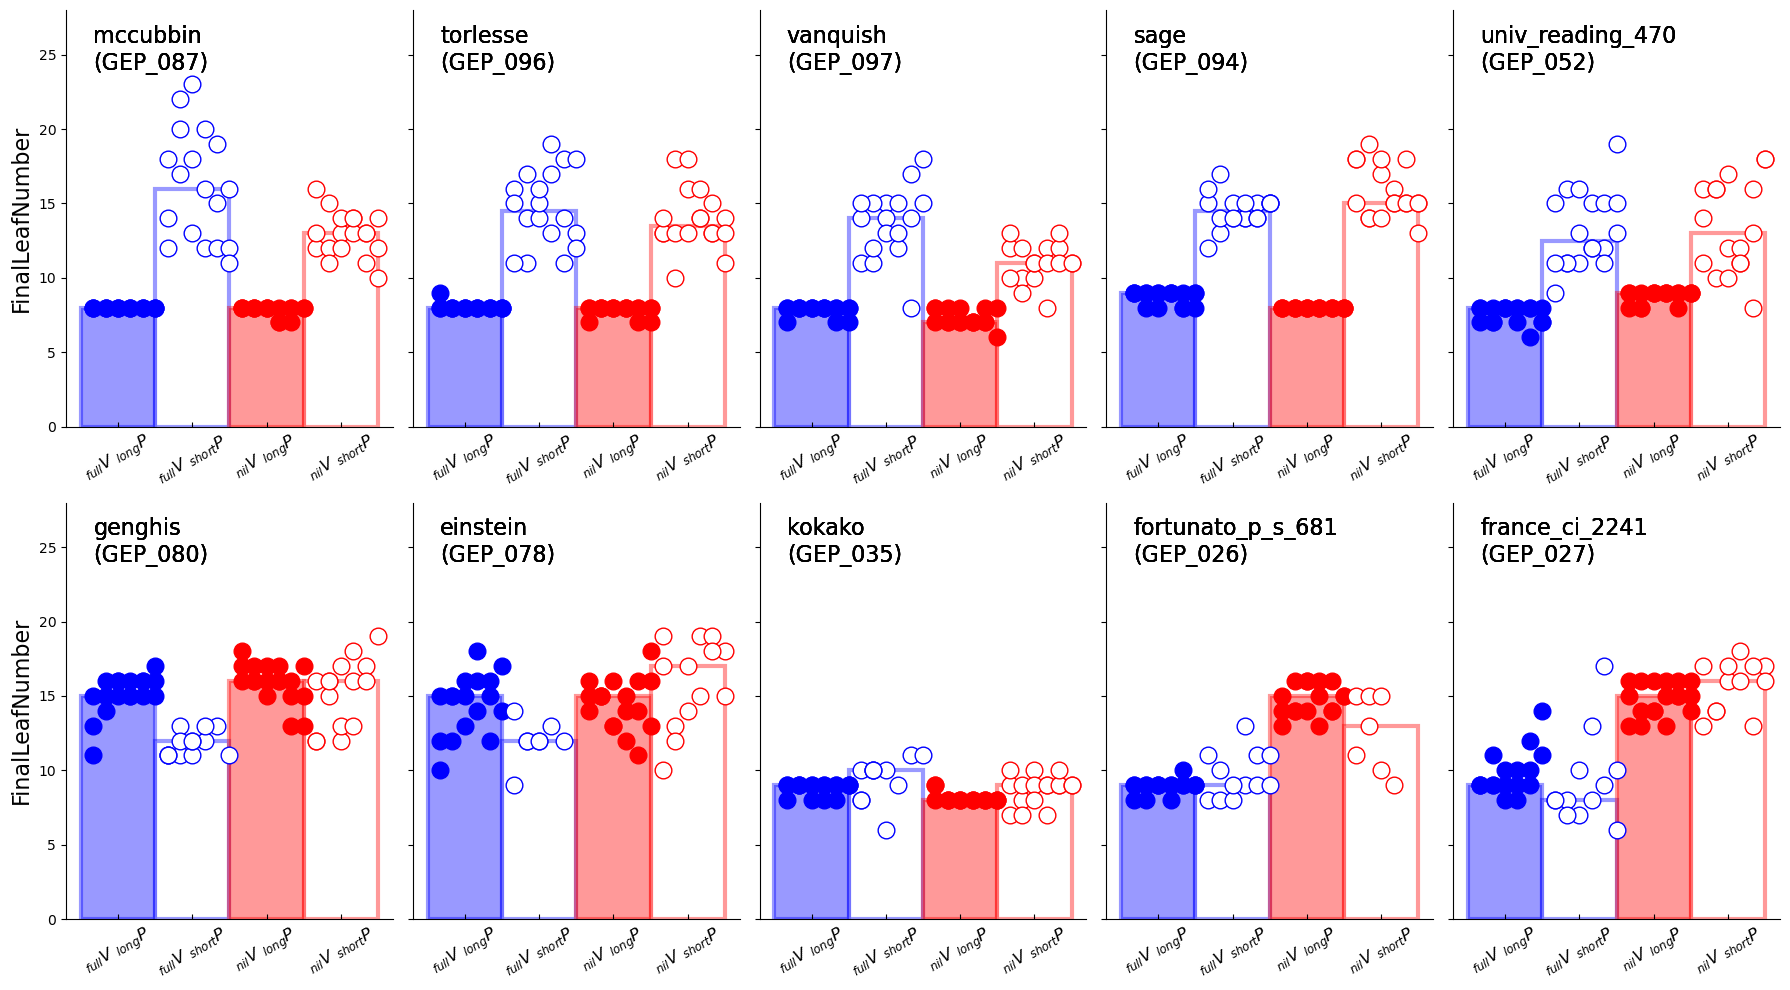

In [42]:
#Create a figure object
Fig = plt.figure(figsize=(18, 10))
colors = ['b','b','r','r']
fills = ['b','w','r','w']
Pos = 1
for Geno in ['GEP_087','GEP_096','GEP_097','GEP_094','GEP_052',
             'GEP_080','GEP_078','GEP_035','GEP_026','GEP_027']:
    Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis) 
    Pos += 1
Fig.tight_layout()
Fig.patch.set_facecolor('white')

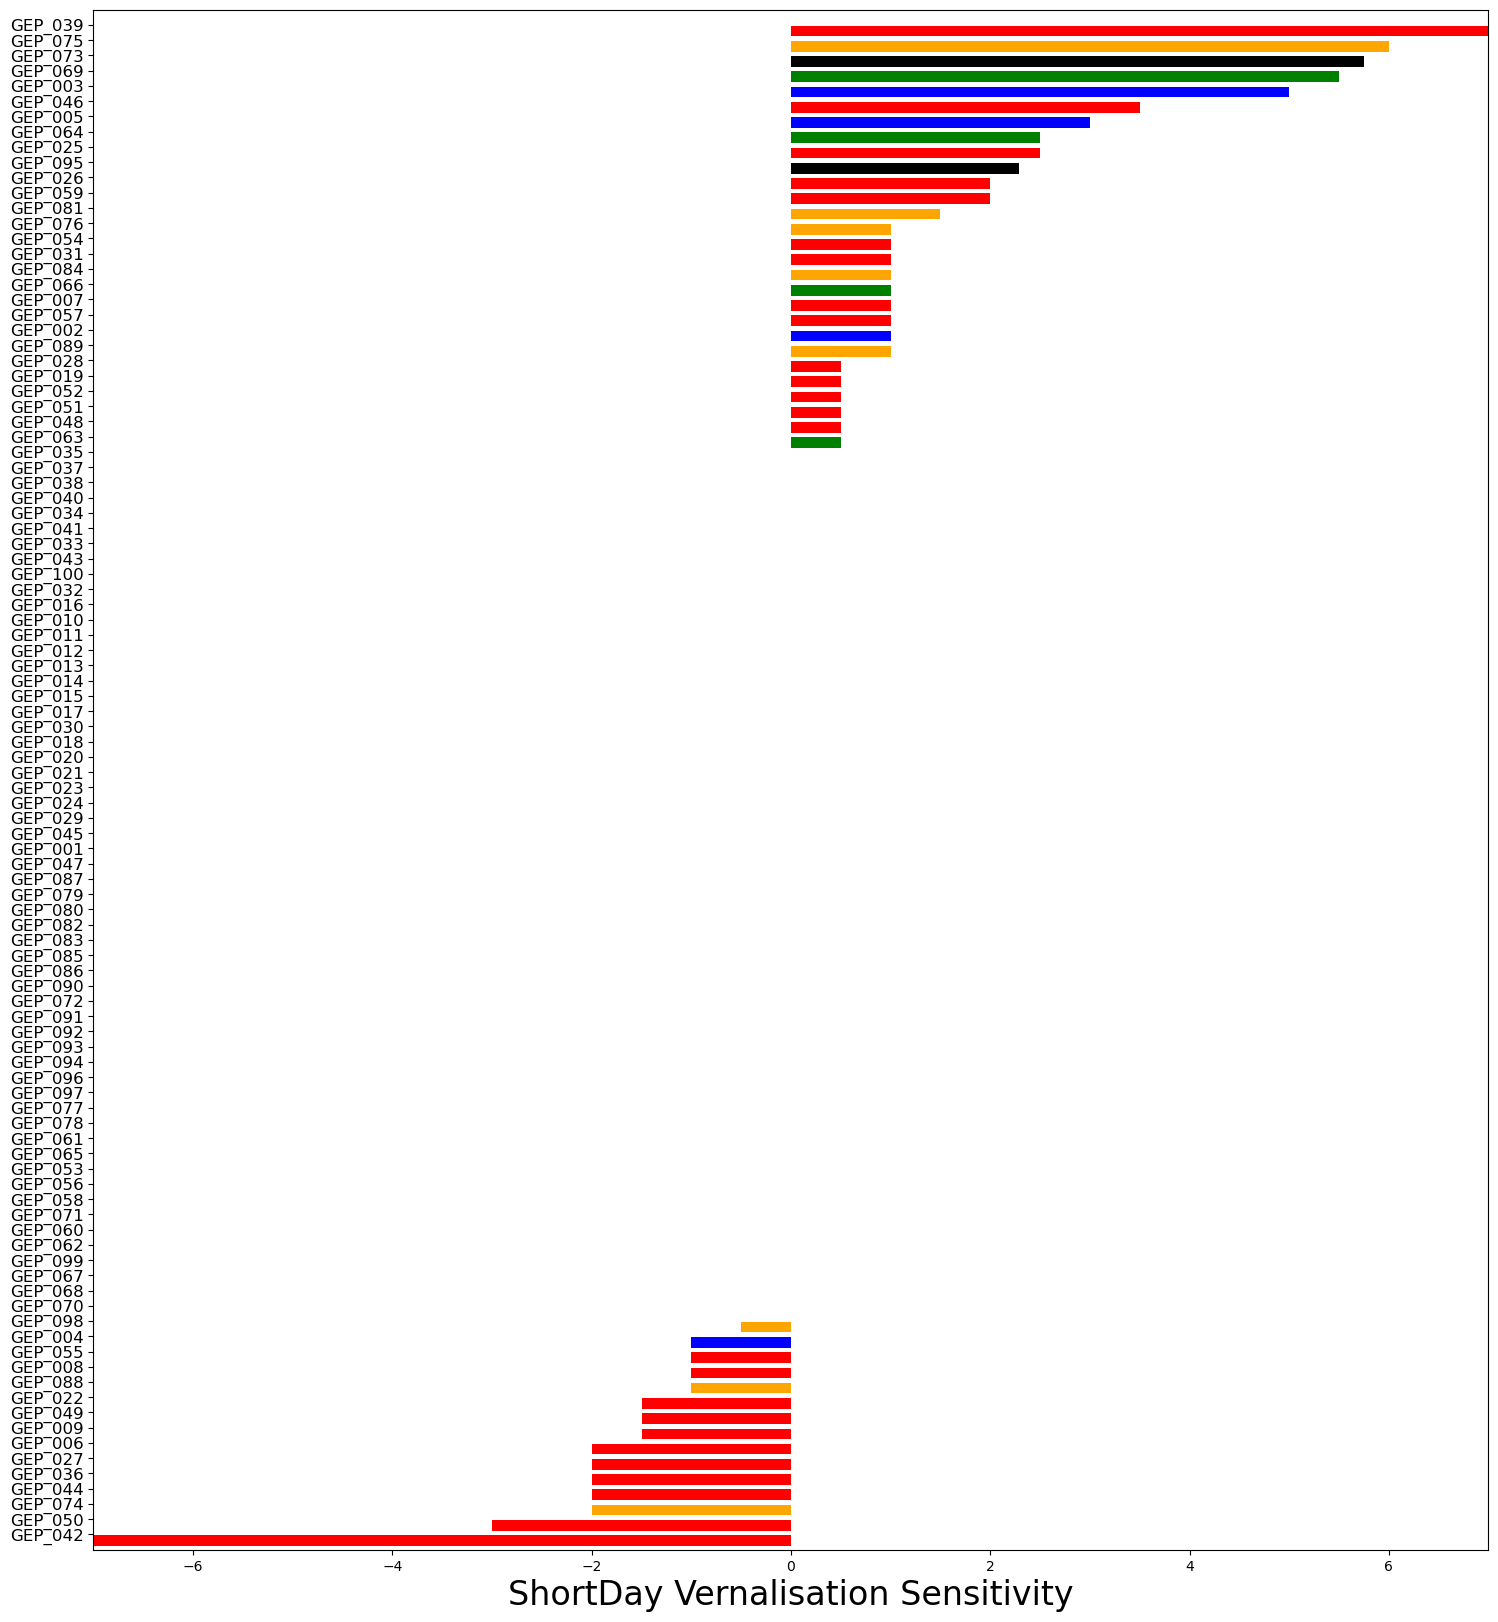

In [43]:
Colors = [SeedColors.loc[Phenotypes.loc[SDVnSensOrder,'Seed group'][x],'Colors'] for x in range(Phenotypes.index.size)]
depth = 0.7
ind = np.arange(100) - 0.4
fig, ax = plt.subplots(figsize=(18, 20))
ax.bar(x=0, width = Phenotypes.loc[SDVnSensOrder,'SDVnSens'],height = depth, bottom=ind,color = Colors,orientation='horizontal')
ax.set_yticks(range(0,100))
ax.set_yticklabels(Phenotypes.loc[SDVnSensOrder,'TidyName'].index,fontsize=12)
ax.set_xlim(-7,7)
ax.set_ylim(-1,100)
ax.set_xlabel('ShortDay Vernalisation Sensitivity',fontsize=24)
Fig.patch.set_facecolor('white')

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\985998818.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


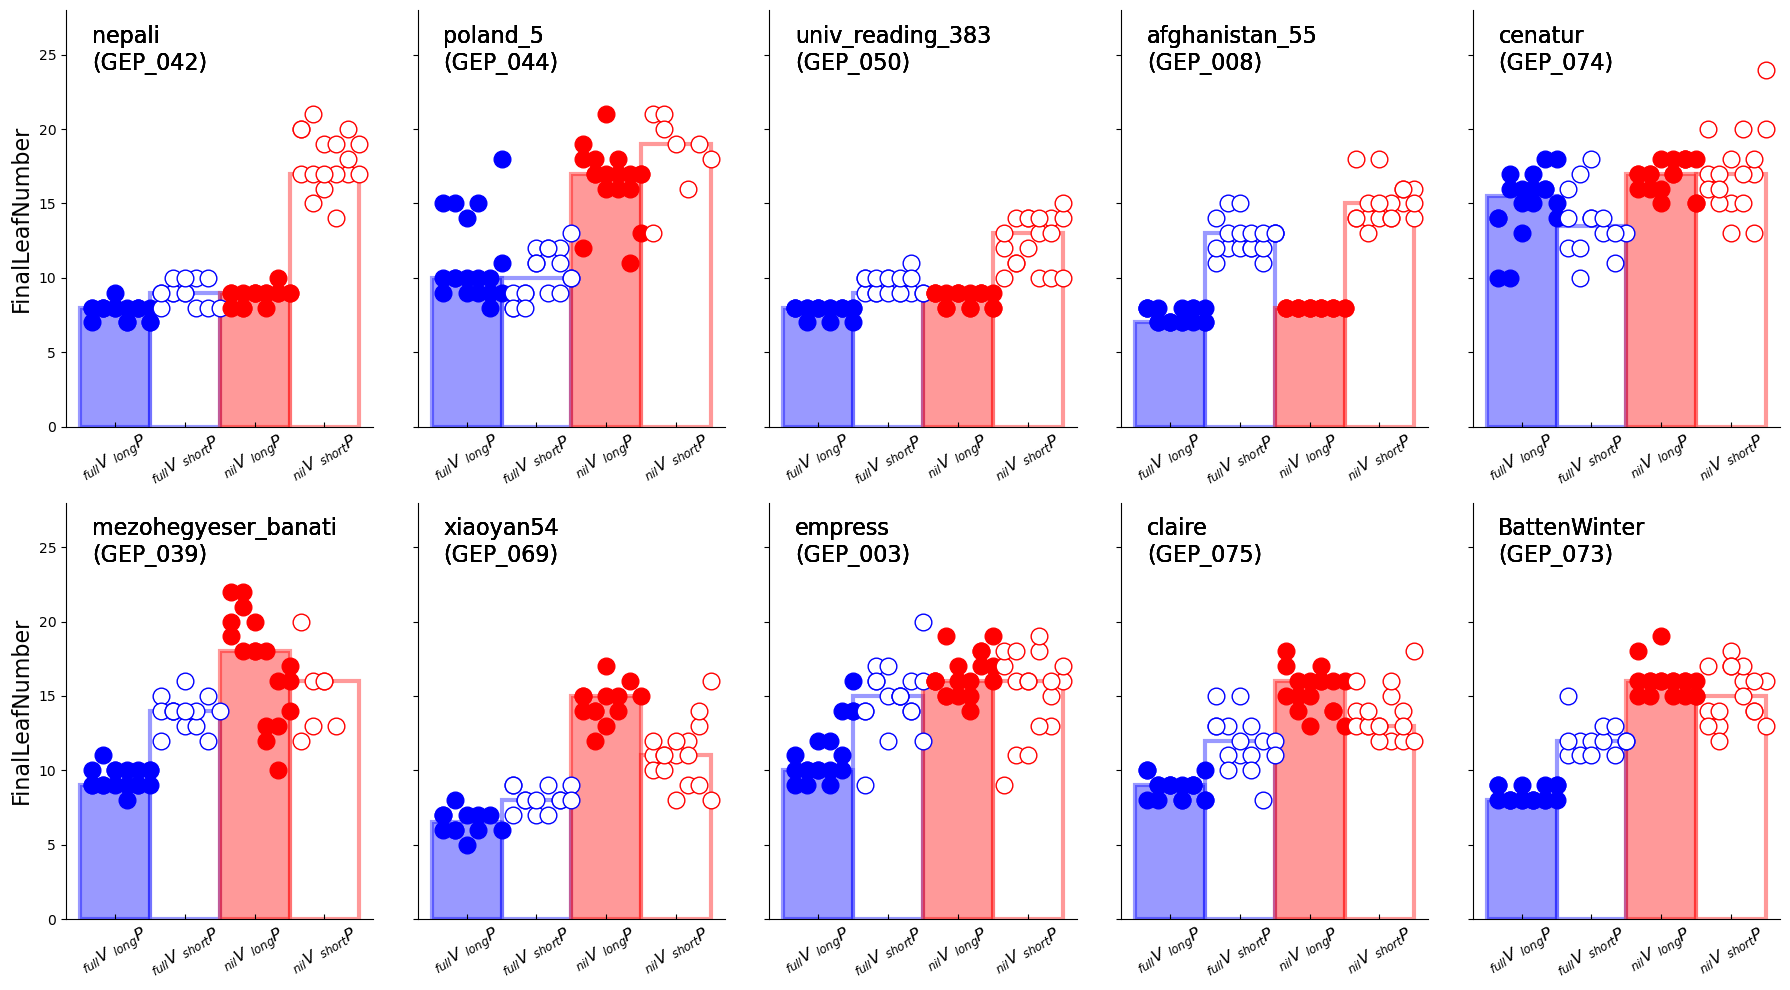

In [44]:
#Create a figure object
Fig = plt.figure(figsize=(18, 10))
colors = ['b','b','r','r']
fills = ['b','w','r','w']
Pos = 1
for Geno in ['GEP_042','GEP_044','GEP_050','GEP_008','GEP_074',
             'GEP_039','GEP_069','GEP_003','GEP_075','GEP_073']:
    Axis = Fig.add_subplot(2,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis) 
    Pos += 1
Fig.tight_layout()
Fig.patch.set_facecolor('white')

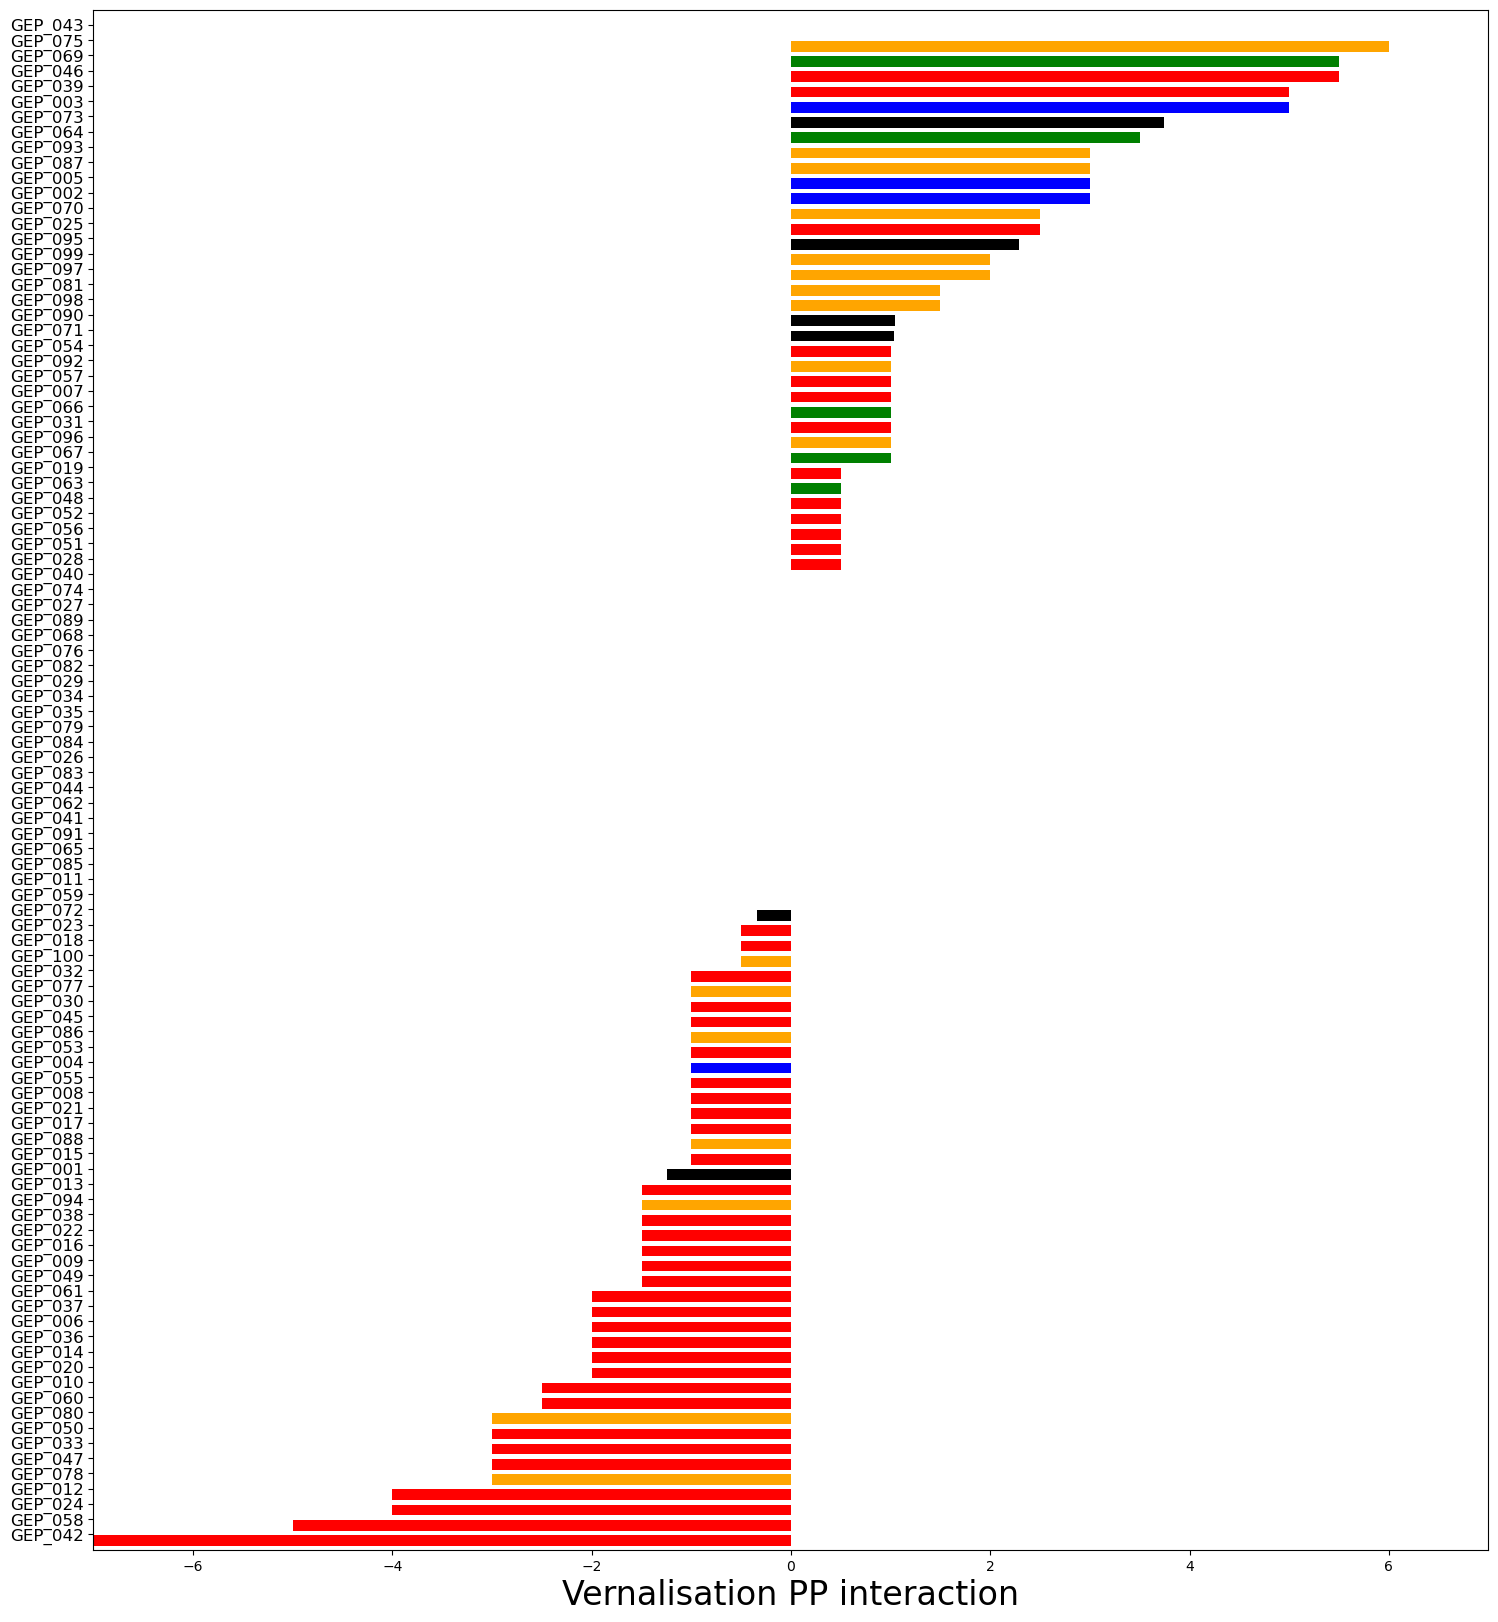

In [45]:
Colors = [SeedColors.loc[Phenotypes.loc[VnPPintOrder,'Seed group'][x],'Colors'] for x in range(Phenotypes.index.size)]
depth = 0.7
ind = np.arange(100) - 0.4
fig, ax = plt.subplots(figsize=(18, 20))
ax.bar(x=0, width = Phenotypes.loc[VnPPintOrder,'VnPPint'],height = depth, bottom=ind,color = Colors,orientation='horizontal')
ax.set_yticks(range(0,100))
ax.set_yticklabels(Phenotypes.loc[VnPPintOrder,'TidyName'].index,fontsize=12)
ax.set_xlim(-7,7)
ax.set_ylim(-1,100)
ax.set_xlabel('Vernalisation PP interaction',fontsize=24)
Fig.patch.set_facecolor('white')

In [46]:
for g in Genotypes:
        if Phenotypes.loc[g,'VernSens']<1.0:
            SDVnSens[g] = 0

## Look at the parameters for a specific genotype relative to all others

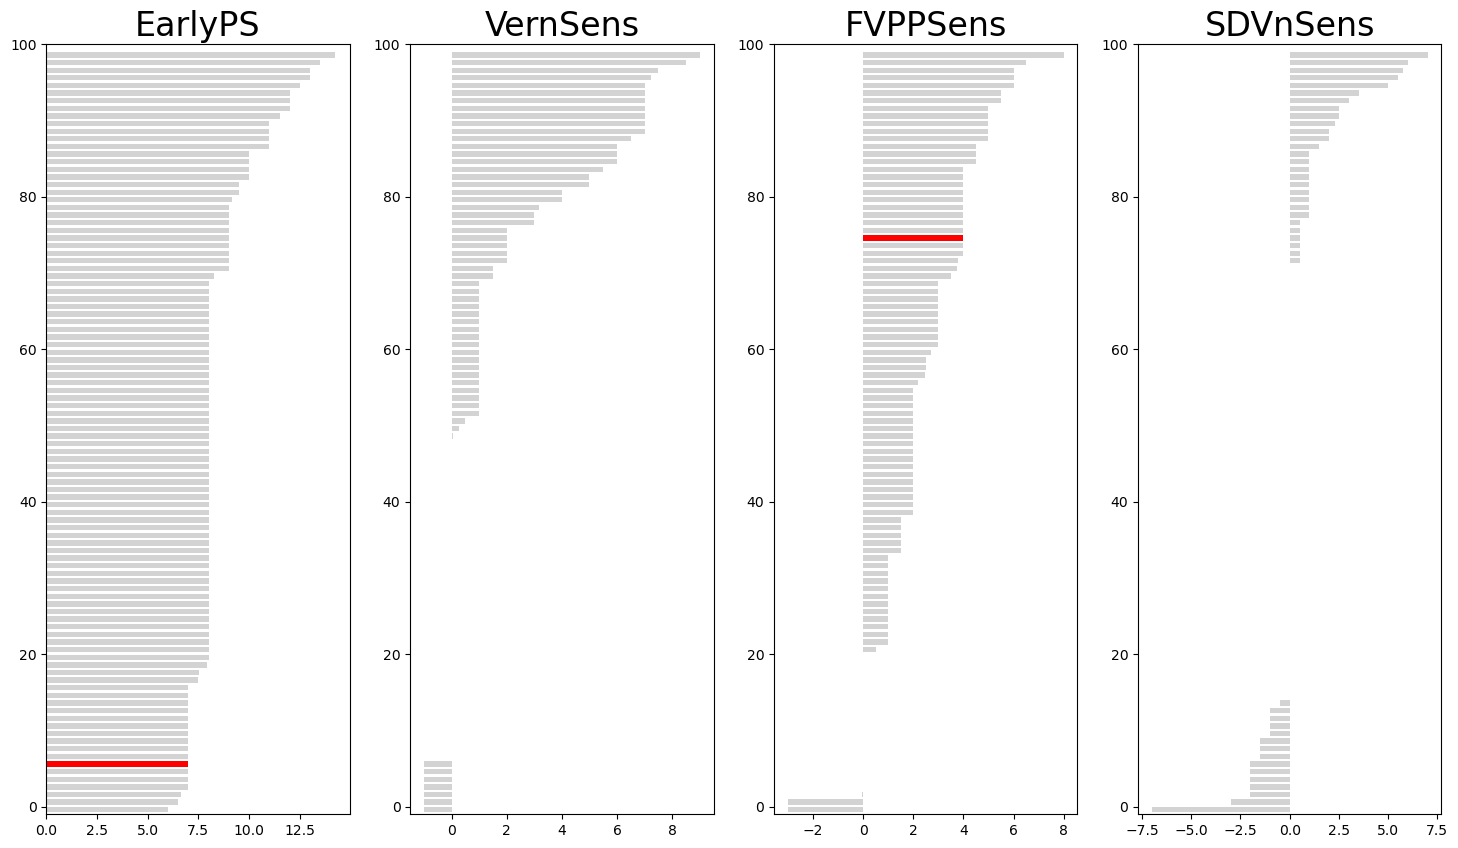

In [47]:
GenotypeID = 'GEP_043'
def GenoColor(genoID,currentID):
    if genoID == currentID:
        return 'red'
    else:
        return 'lightgrey'
checkGeno = Phenotypes.loc[GenotypeID,:]

Graph = plt.figure(figsize=(18,10))
depth = 0.7
ind = np.arange(100) - 0.4
p=1
sortOrders = [EarlyPSOrder,VernSensOrder,FVPPSensOrder,SDVnSensOrder]
for var in [ 'EarlyPS', 'VernSens','FVPPSens', 'SDVnSens']:
    ax = Graph.add_subplot(1,4,p)
    ax.bar(x=0, width = Phenotypes.loc[sortOrders[p-1],var],height = depth, bottom=ind,
           color = [GenoColor(GenotypeID,x) for x in sortOrders[p-1]],orientation='horizontal')
    ax.set_ylim(-1,100)
    plt.title(var,fontsize=24)
    p+=1
Fig.patch.set_facecolor('white')

In [48]:
CoreGroupGEPIDs = MasterIndex.loc[MasterIndex.loc[:,'Seed group']=='Core',:].index

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_11924\3484636832.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  Axis = Fig.add_subplot(21,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])


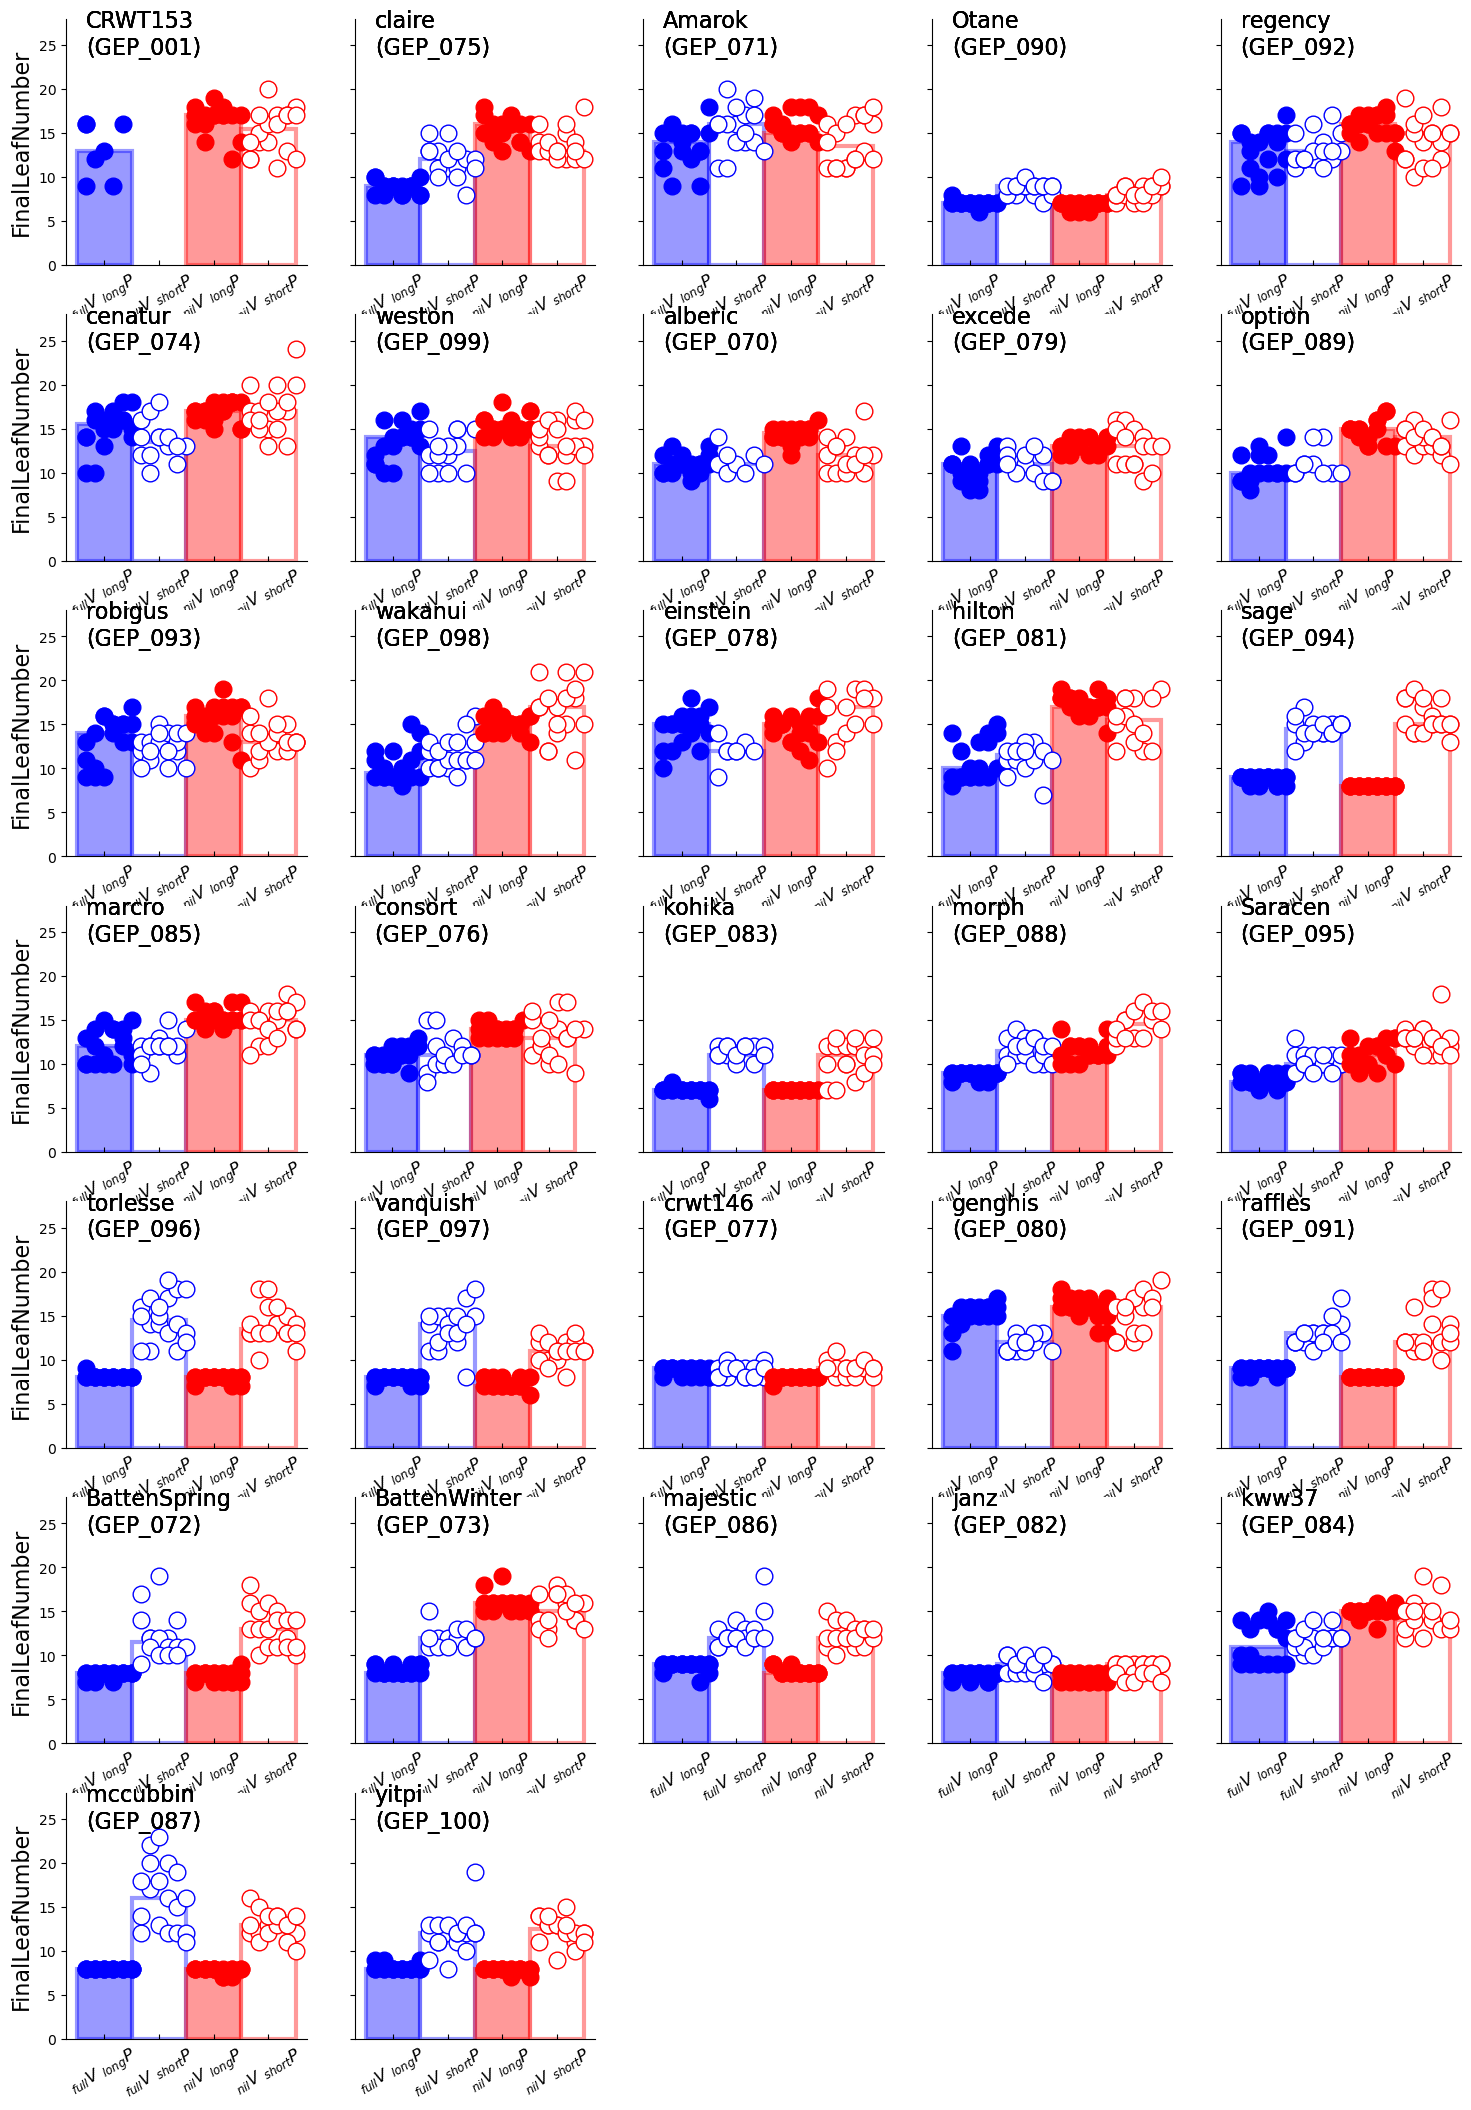

In [49]:
Fig = plt.figure(figsize=(18, 80))
Pos = 1
for Geno in CommonGenotypes:
    Axis = Fig.add_subplot(21,5,Pos,xticklabels=['$_{full}V$ $_{long}P$','$_{full}V$ $_{short}P$', '$_{nil}V$ $_{long}P$', '$_{nil}V$ $_{short}P$'])
    MakeGenotypeBarPlot(Geno,Axis)  
    Pos += 1
Fig.patch.set_facecolor('white')
#Fig.savefig('FLN.pdf',format='pdf',dpi=300)  
Fig.patch.set_facecolor('white')

In [50]:
Phenotypes.reset_index(inplace=True)

In [51]:
ParamNameMap = {
    'TidyName': 'Cultivar',
    'LV_FLN': '[Phenology].CAMP.FLNparams.CL',
    'LN_FLN': '[Phenology].CAMP.FLNparams.WL', 
    'SV_FLN': '[Phenology].CAMP.FLNparams.CS',
    'SN_FLN': '[Phenology].CAMP.FLNparams.WS'
}  

In [52]:
CampInputs = Phenotypes.loc[:,['TidyName', 'LV_FLN', 'SV_FLN','LN_FLN', 'SN_FLN']].copy()
CampInputs.columns = [ParamNameMap[x] for x in CampInputs.columns]
CampInputs.set_index('Cultivar',inplace=True)
CampInputs.loc[:,'VrnTreatTemp'] = 1.0
CampInputs.loc[:,'VrnTreatDuration'] = 90
CampInputs.loc[:,'Expt'] = 'LincolnBioTron'
CampInputs.to_excel('.\ProcessedData\CEParamsFLN_NZ96.xlsx',sheet_name='ObservedParams')

In [53]:
CampInputs.loc['BattenWinter']

[Phenology].CAMP.FLNparams.CL          8.277778
[Phenology].CAMP.FLNparams.CS            12.025
[Phenology].CAMP.FLNparams.WL              15.5
[Phenology].CAMP.FLNparams.WS              13.5
VrnTreatTemp                                1.0
VrnTreatDuration                             90
Expt                             LincolnBioTron
Name: BattenWinter, dtype: object

In [54]:
FLNData.loc[FLNData.TidyName=='wakanui','FinalLigualeNumber'].values

array([ 9.5, 15. , 11. , 17. ])

In [55]:
list(FLNData.TidyName.drop_duplicates())

['CRWT153',
 'crwt168',
 'empress',
 'hrz07_0097_springtype',
 'hrz07_0097_wintertype',
 '374_q7_a4',
 'afghanistan_48',
 'afghanistan_55',
 'cnt_1',
 'darius_gli_di',
 'doyo_333',
 'doyo_4',
 'doyo_7',
 'doyo_924',
 'doyo_961',
 'etaya_26',
 'etaya_28',
 'etaya_31',
 'etaya_32',
 'etaya_33',
 'etaya_34',
 'ex_iraq_39',
 'ex_iraq_40',
 'ex_iraq_50',
 'ex_morocco_27',
 'fortunato_p_s_681',
 'france_ci_2241',
 'goya',
 'intoto_24',
 'intoto_3',
 'intoto_4',
 'intoto_5',
 'intoto_8',
 'kenya_page',
 'kokako',
 'libellula',
 'lontra',
 'lyallpur_18',
 'mezohegyeser_banati',
 'nada_2',
 'nada_3',
 'nepali',
 'oroua',
 'poland_5',
 'pusa_101',
 'pusa_54',
 'rongotea',
 'sind_30',
 'trigo_colonial',
 'univ_reading_383',
 'univ_reading_456',
 'univ_reading_470',
 'univ_reading_506',
 'univ_reading_522',
 'univ_reading_96',
 'univ_reading_a1120',
 'univ_reading_a1804',
 'univ_reading_a1805',
 'univ_reading_a1829',
 'univ_reading_a310',
 'yaktana_5',
 'acbarrie',
 'alsen',
 'baxter',
 'chara',
 